# Glass type dataset - clustering

No collaboration

External resources:


*   The example (Beans) notebook
    * Whole `helpers.py` file contains snippets from beans notebook (mostly plotting functions)
    * There are little parts present in this notebook (they are marked with a respective comment)

*   [numpy documentation](https://numpy.org/doc/)
*   [pandas documentation](https://pandas.pydata.org/docs/)
*   [matplotlib documentation](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)
*   [sklearn documentation](https://scikit-learn.org/stable/)



First, classic data analysis imports:

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster, metrics

import helpers as h

Seeding (copied from the example notebook):

In [ ]:
SEED = 2407741
RS = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(SEED)))

## Data presentation

First, we load the dataset (URL of the dataset [here](https://archive.ics.uci.edu/dataset/42/glass+identification)):

In [ ]:
header = [ "id", "ri", "na", "mg", "al", "si", "k", "ca", "ba", "fe", "type"]

df = pd.read_csv("glass.data", names=header)
df.head()

id       ri     na    mg    al     si     k    ca   ba   fe  type
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

The dataset contains glass samples described by the weight percentage of 8 chemical elements typically present in the glass together with the [refractive index](https://en.wikipedia.org/wiki/Refractive_index) of the sample. Each sample also contains information about the type of glass (label) taking 1 of 7 possible values.

Let's have a look at summary statistics of our dataset:

In [ ]:
label = df["type"]
df = df.drop(["id", "type"], axis=1)

print(np.unique(label))

df.describe()

[1 2 3 5 6 7]


ri          na          mg          al          si           k  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               ca          ba          fe  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%      8.600000    0.000000    0.000000  
75%      9.172500    0.000000    0.100000  
max     16.190000    3.150000    0.510000

We can see that we have 214 samples with no missing values. We can also see that the majority of weight of a sample consists of silicon particles (expectedly) on average. Regarding the refractive index values, they are very similar for each sample.

Also notice that the intended number of classes is 7, but one class has no members.

Let's observe correlation between every pair of attributes and see whether there is any linear relation between the attributes:

<Axes: >

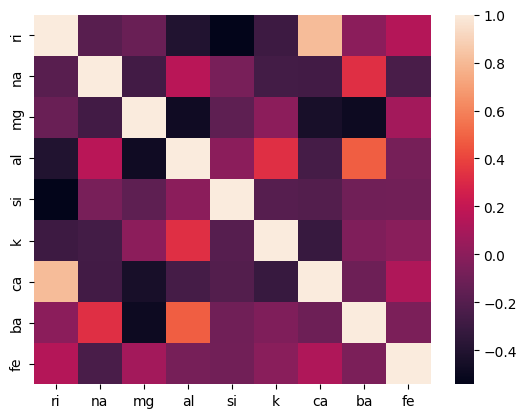

In [ ]:
sns.heatmap( df.corr() )

We see no very high correlation between any pair of attributes (except ri-ca which shows quite high level). The reason for the slightly negative correlation for many pairs might be the nature of the data. Since each attribute (besides refraction index) represents a fraction of weight taken by given element, all values for each sample must sum up to 1(00%). This implies that with an increase of one value, there must be a decrease of other values.

Since there are dependencies between each pair of element attributes and they all sum up to a constant, it does not make sense to use standard normalization techniques like min-max or standard scaling since they would distort this crucial relation between attributes. For such data, centre log ratio (CLR) transformation is often used. Regarding the refraction index, we will not use this attribute since it is very similar for each sample, thus, bringing little of information.

In [ ]:
def clr_transform(sample, eps=1e-9):
    sample = sample.replace(0, eps)
    geometric_mean = np.exp(np.mean(np.log(sample)))
    return np.log(sample / geometric_mean)

df.drop("ri", axis=1, inplace=True)
df = df.apply(clr_transform, axis=1)
df

na         mg        al         si          k        ca         ba  \
0    6.813896   5.702742  4.296199   8.474495   1.387478  6.369943 -16.522377   
1    6.583194   5.232958  4.259509   8.238779   3.218055  6.009987 -16.771241   
2    6.572737   5.234775  4.399610   8.258150   3.026219  6.019384 -16.755438   
3    6.515441   5.240093  4.189109   8.219570   3.372348  6.041037 -16.788799   
4    6.532702   5.233670  4.162308   8.238751   3.349359  6.035350 -16.776070   
..        ...        ...       ...        ...        ...       ...        ...   
209  6.862141 -16.510133  5.270923   8.498236   1.687404  6.430160   4.271402   
210  9.189667 -14.236302  7.175099  10.778245 -14.236302  8.615196   6.950698   
211  9.149244 -14.238469  7.187895  10.780994 -14.238469  8.617780   6.979494   
212  9.160051 -14.229053  7.156901  10.792994 -14.229053  8.631923   6.945289   
213  9.132826 -14.245792  7.209842  10.772853 -14.245792  8.631559   6.990297   

            fe  
0   -16.522377  
1   -16.771241  
2   -16.755438  
3   -16.788799  
4   -16.776070  
..         ...  
209 -16.510133  
210 -14.236302  
211 -14.238469  
212 -14.229053  
213 -14.245792  

[214 rows x 8 columns]

Let us have a look on the correlation matrix after applying CLR:

<Axes: >

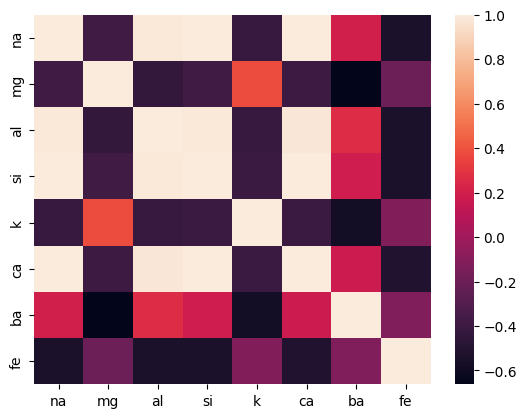

In [ ]:
sns.heatmap( df.corr() )

We an see a lot of correlation now, thus, we can create a reduced dataset containing only one attribute of each group of correlating attributes and compare clusterings obtained from such dataset with other clusterings.

In [ ]:
reduced_df = df[ ["mg", "si", "k", "ba", "fe"] ]

Since we have no intuition or information about which attributes are more essential for defining the glass type, we will preserve all the attributes in our dataset. Since the number of sample is relatively small, we will observe whether the model will be able to use the full information available. Then, we will try to perfrom clustering on reduced version of the dataset and see whether it brings considerable improvements.

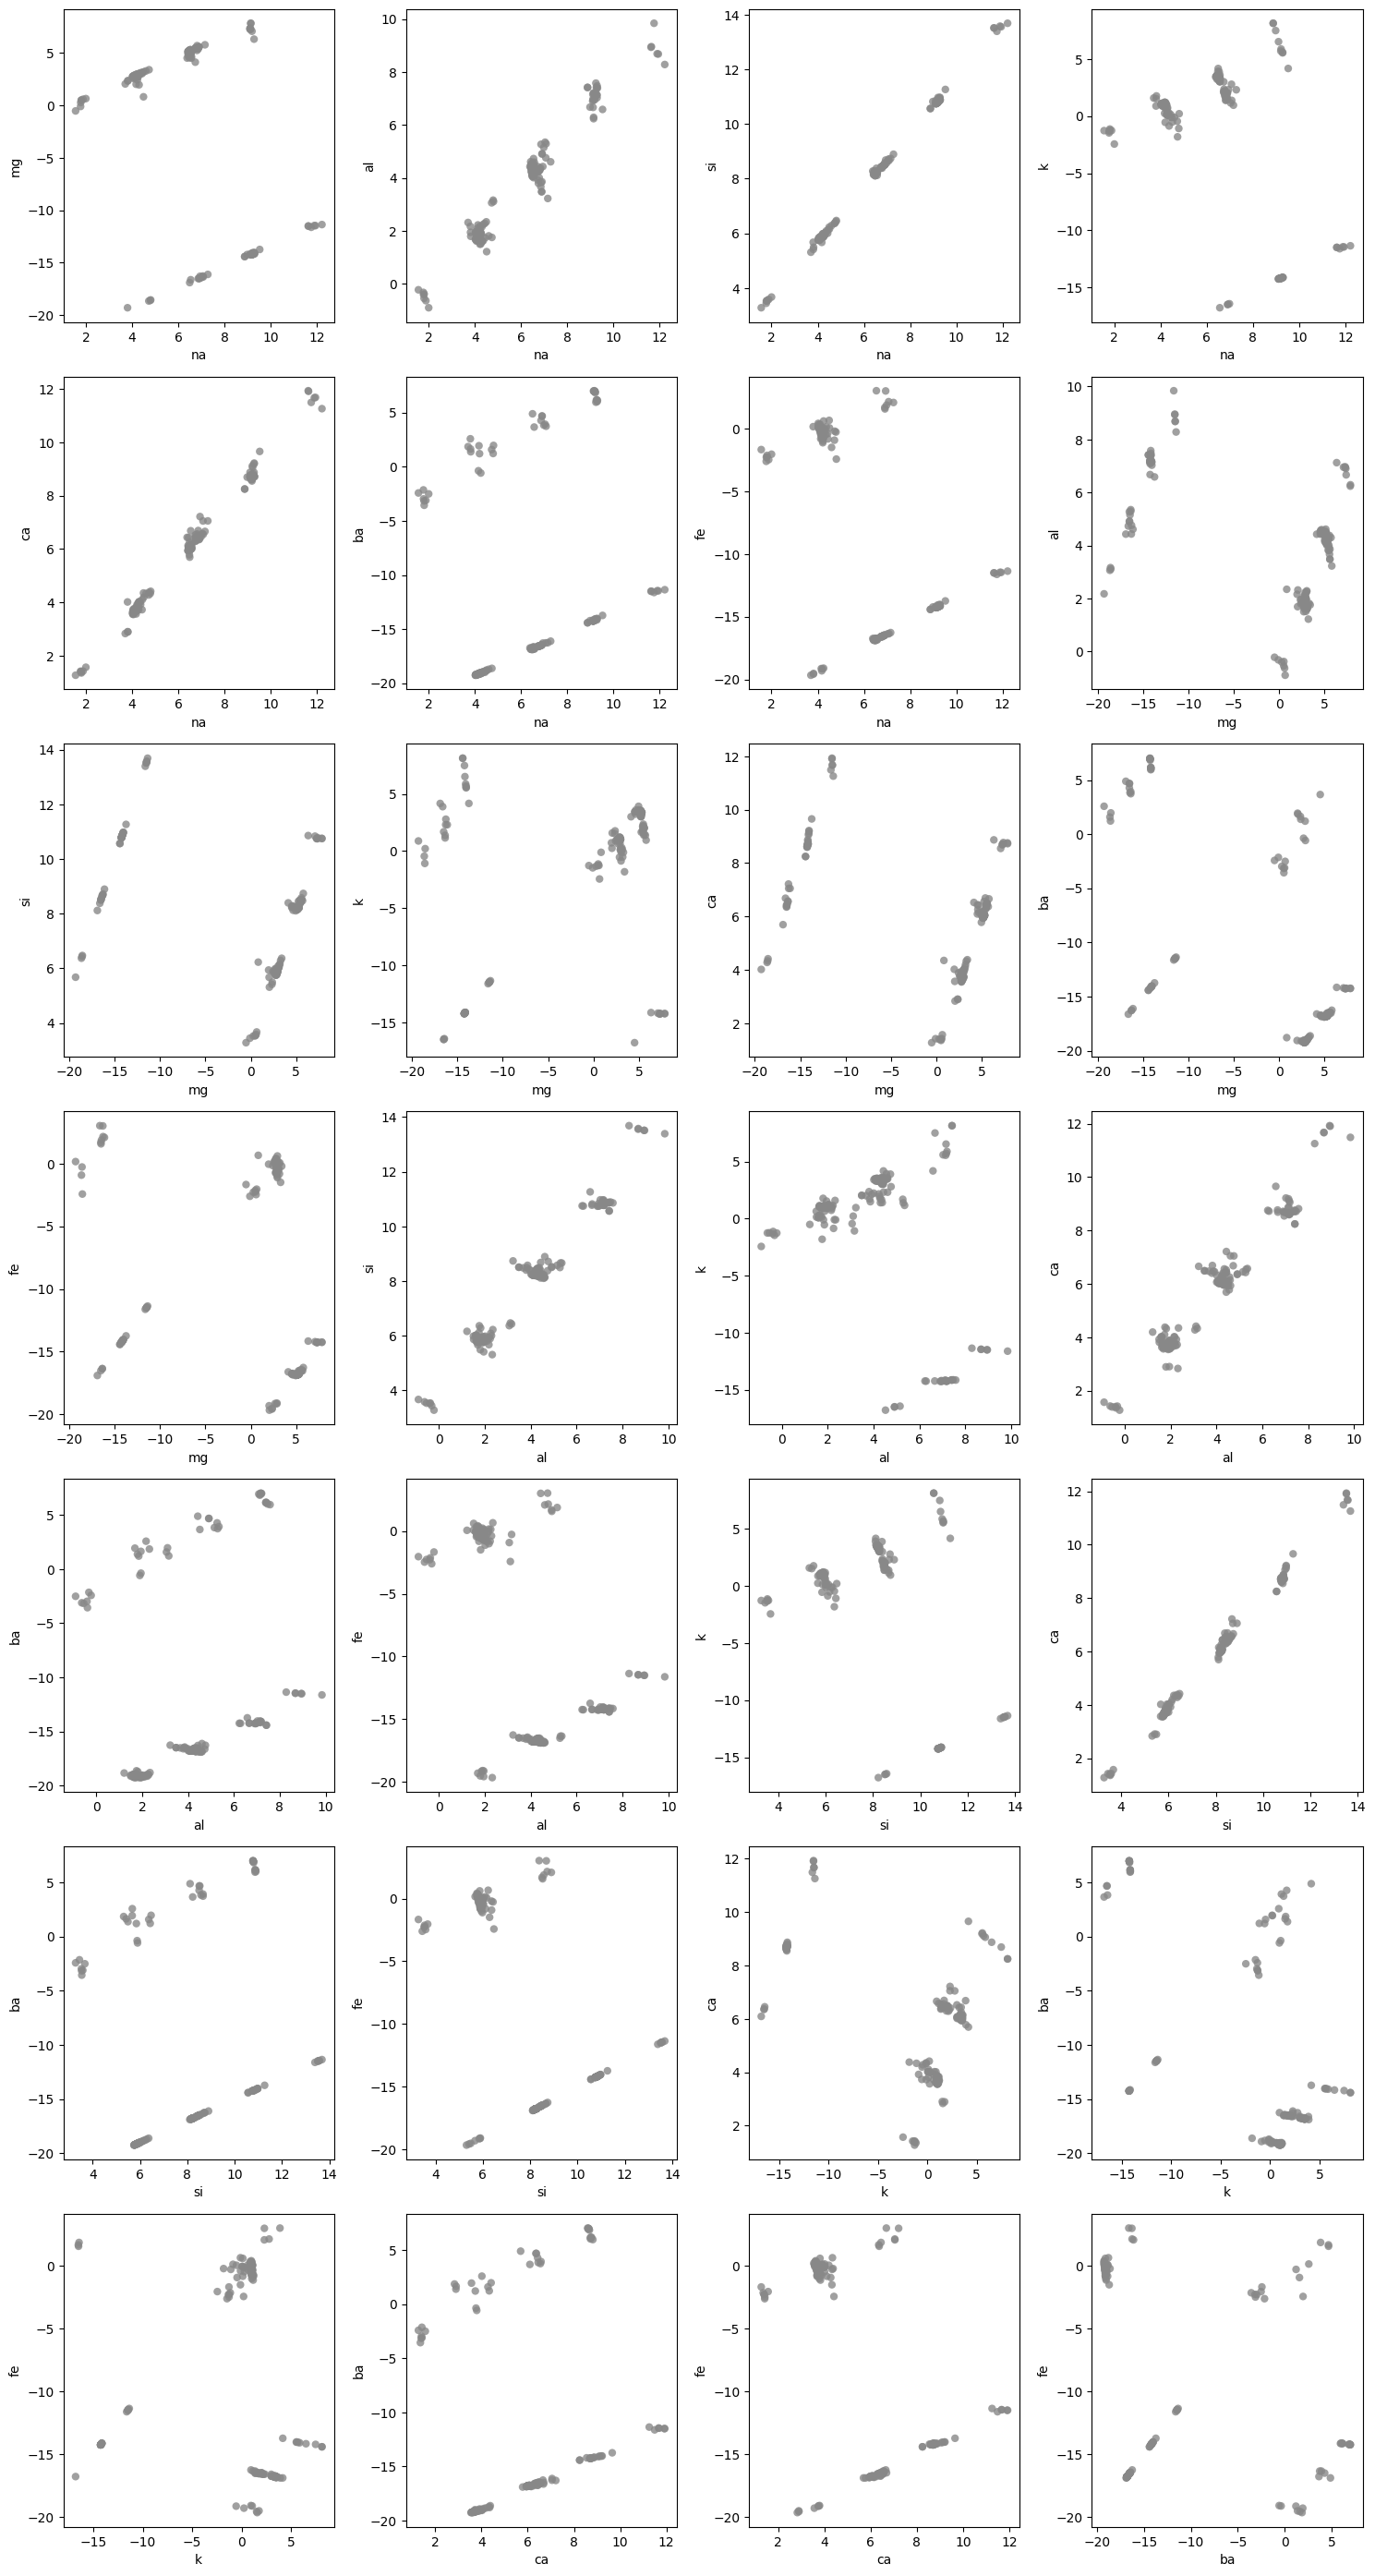

In [ ]:
names = list(df.columns)

pairs = []
for i in range(len(names)):
    for j in range(i + 1, len(names)):
        pairs.append( ( i, j ) )

X = df.to_numpy()

h.plot_data(X, names, pairs)

Same for reduced data.

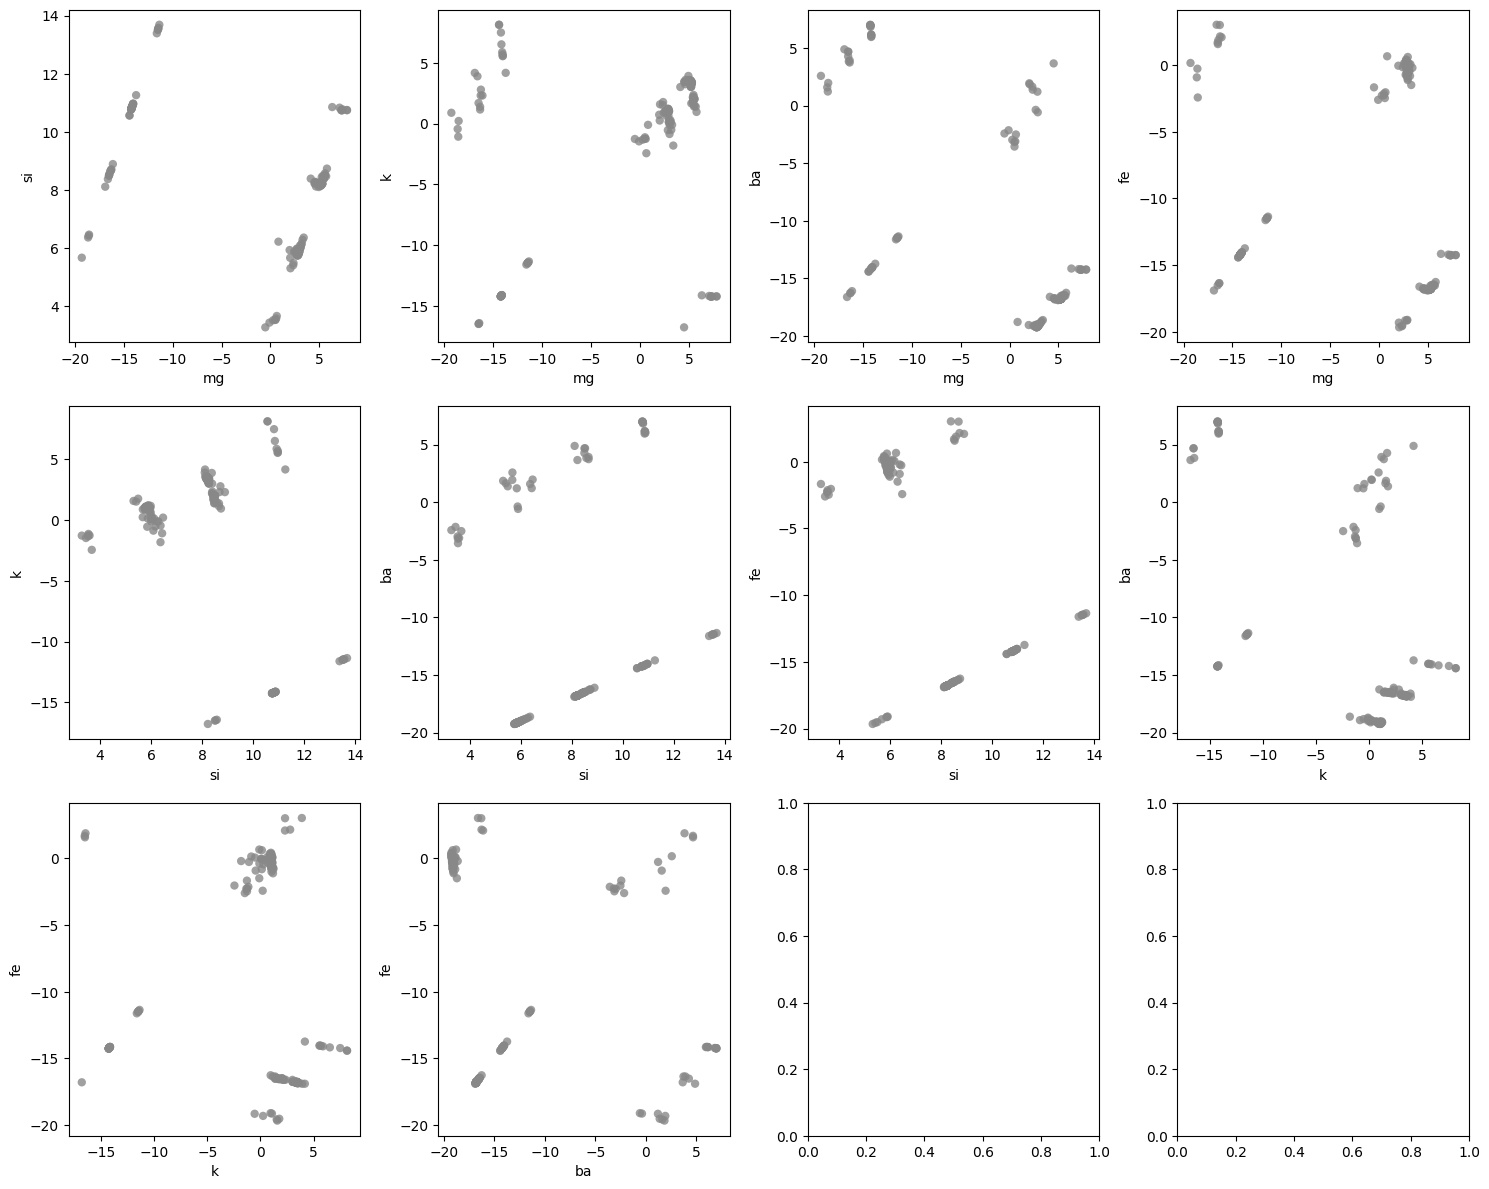

In [ ]:
rnames = list(reduced_df.columns)

rpairs = []
for i in range(len(rnames)):
    for j in range(i + 1, len(rnames)):
        rpairs.append( ( i, j ) )

rX = reduced_df.to_numpy()

h.plot_data(rX, rnames, rpairs)

## K-means clustering

Since we already know that the expected number of clusters is 7, we are going to try k=7. After observing the dataset, we know that one category has 0 samples in it, thus, we will also try k=6.

In [ ]:
clKM7 = cluster.KMeans(n_clusters=7, n_init=10, random_state=RS).fit(X)
clKM_labels7, map_labels7 = h.relabel_clusters_size(clKM7.labels_)

Number of samples in particular clusters: (copied from example notebook)

In [ ]:
np.bincount(clKM_labels7 + 1)

array([ 0, 97, 52, 19, 16, 14,  9,  7])

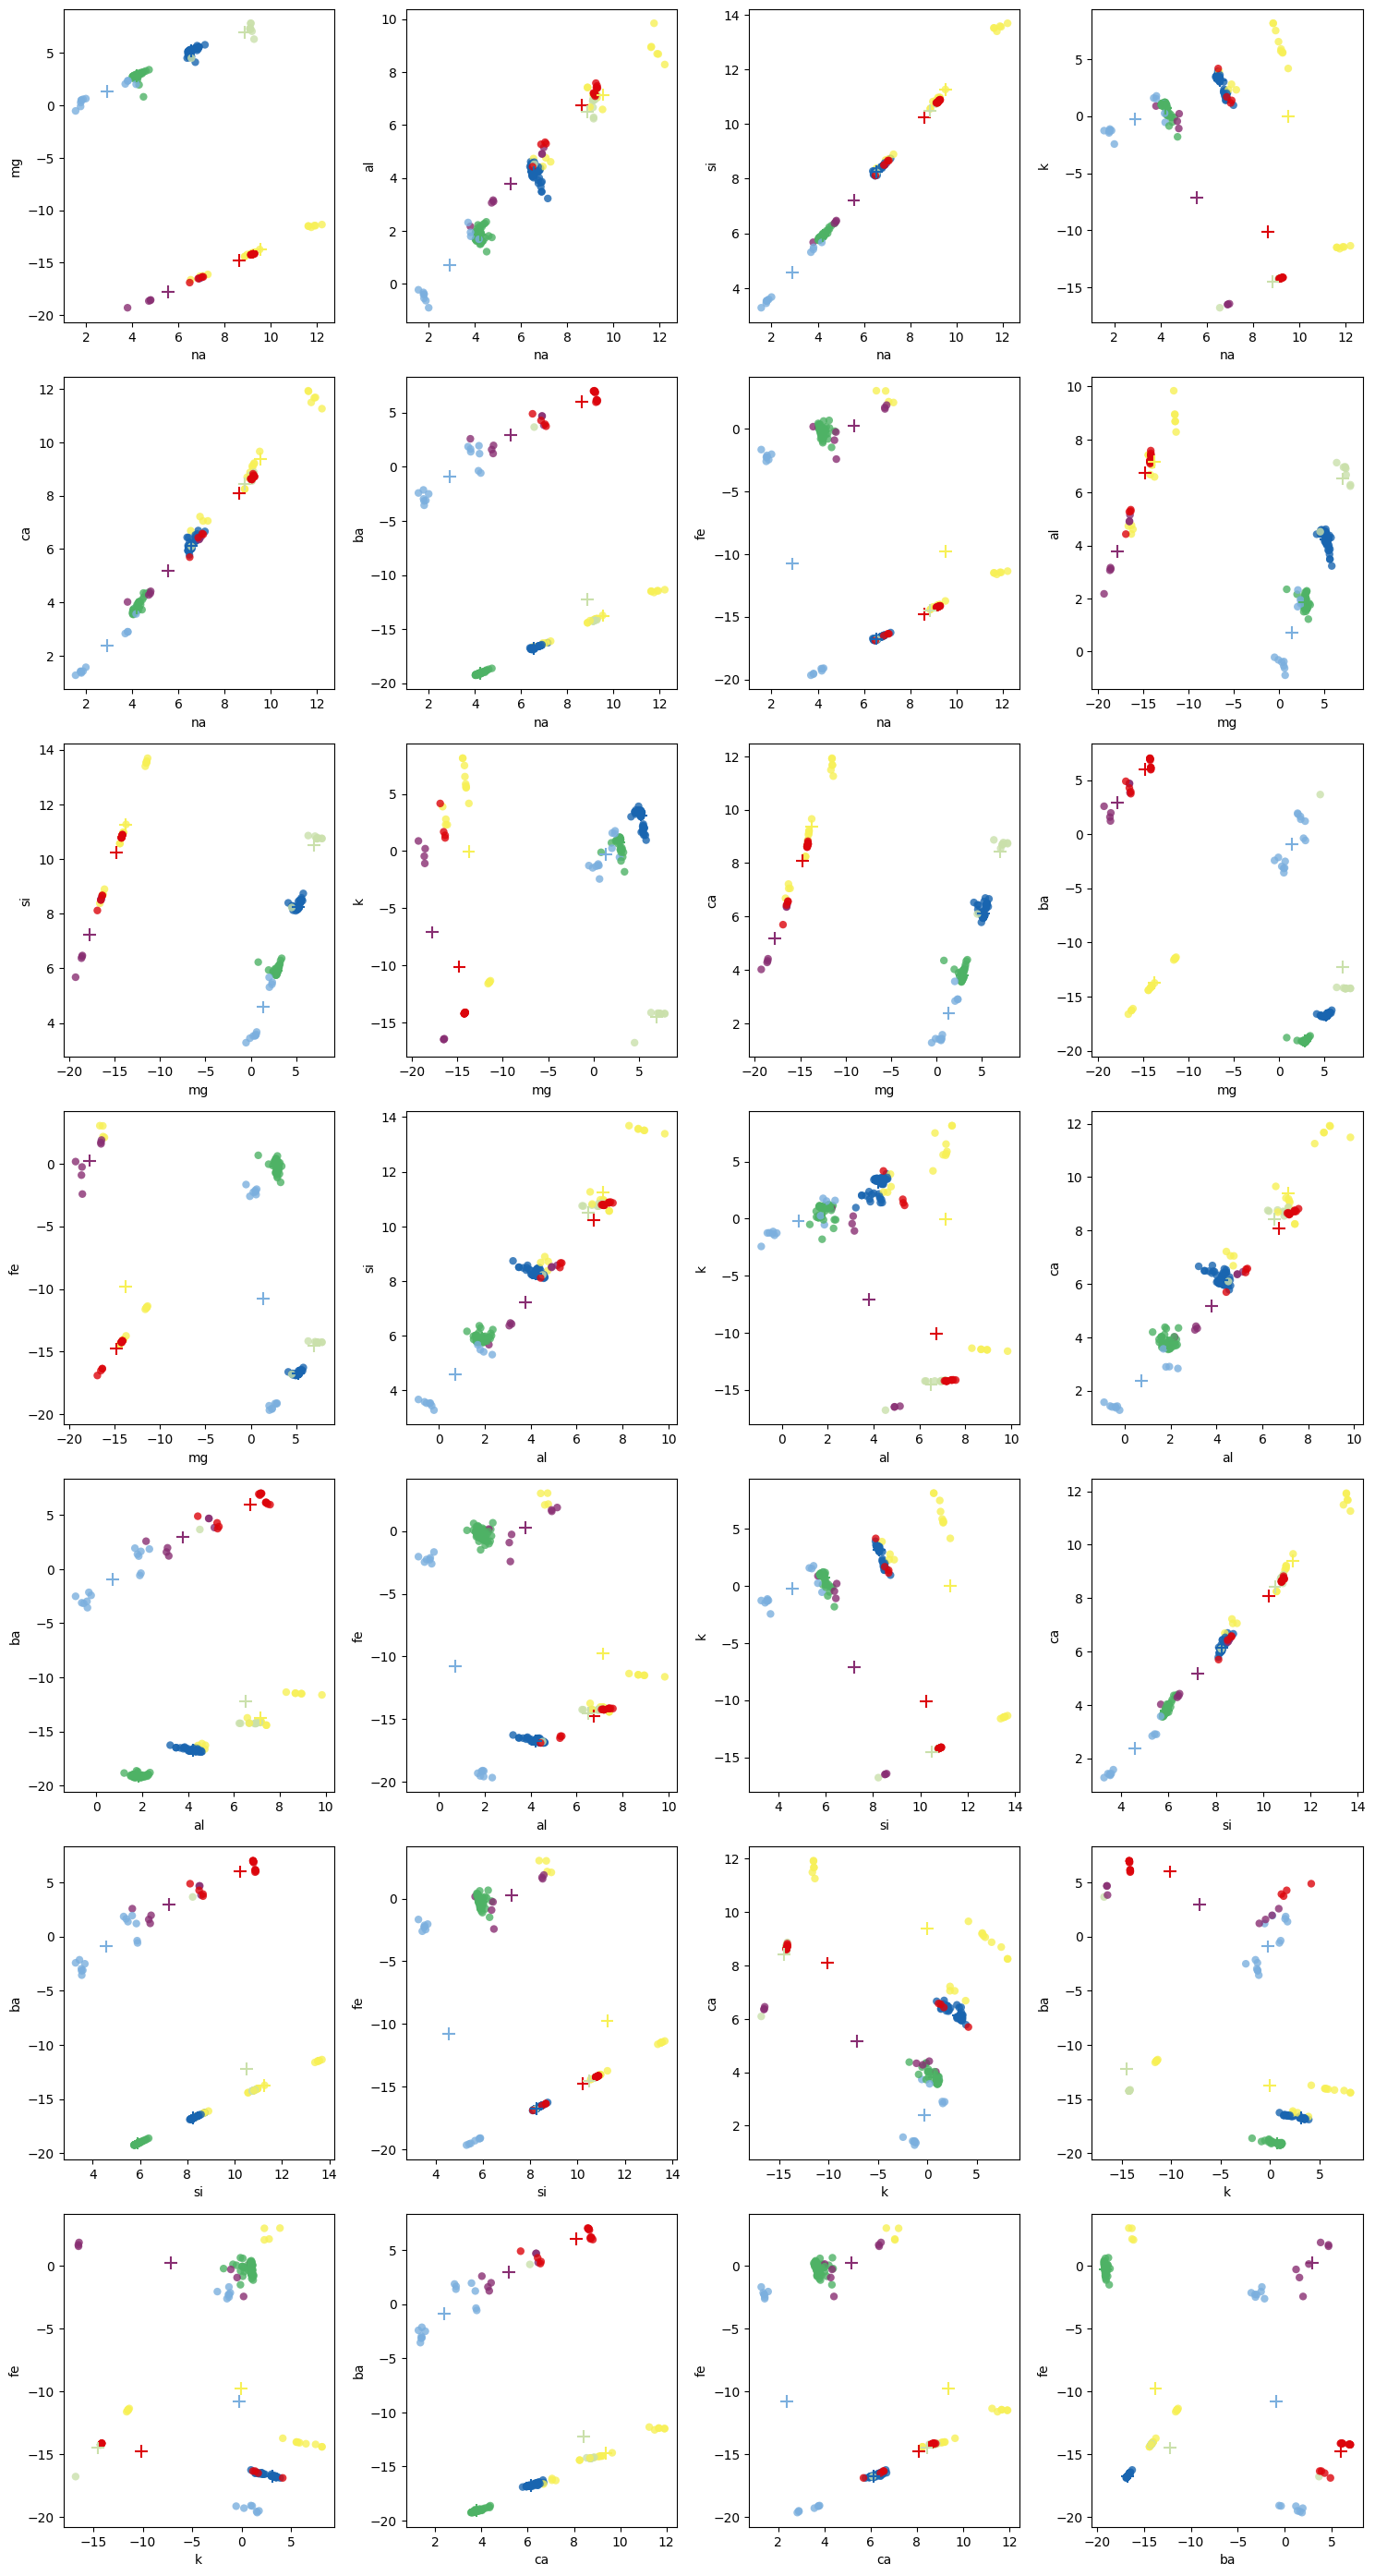

In [ ]:
h.plot_data(X, names, pairs, clKM_labels7, clKM7.cluster_centers_, map_labels7)

It is hard to make any conclussions about the clustering just by observing the plots. We will wait for the evaluation part to decide the quality of the clustering.

Now, we do the same process with 6 clusters.

In [ ]:
clKM6 = cluster.KMeans(n_clusters=6, n_init=10, random_state=RS).fit(X)
clKM_labels6, map_labels6 = h.relabel_clusters_size(clKM6.labels_)

In [ ]:
np.bincount(clKM_labels6 + 1)

array([ 0, 97, 52, 19, 19, 18,  9])

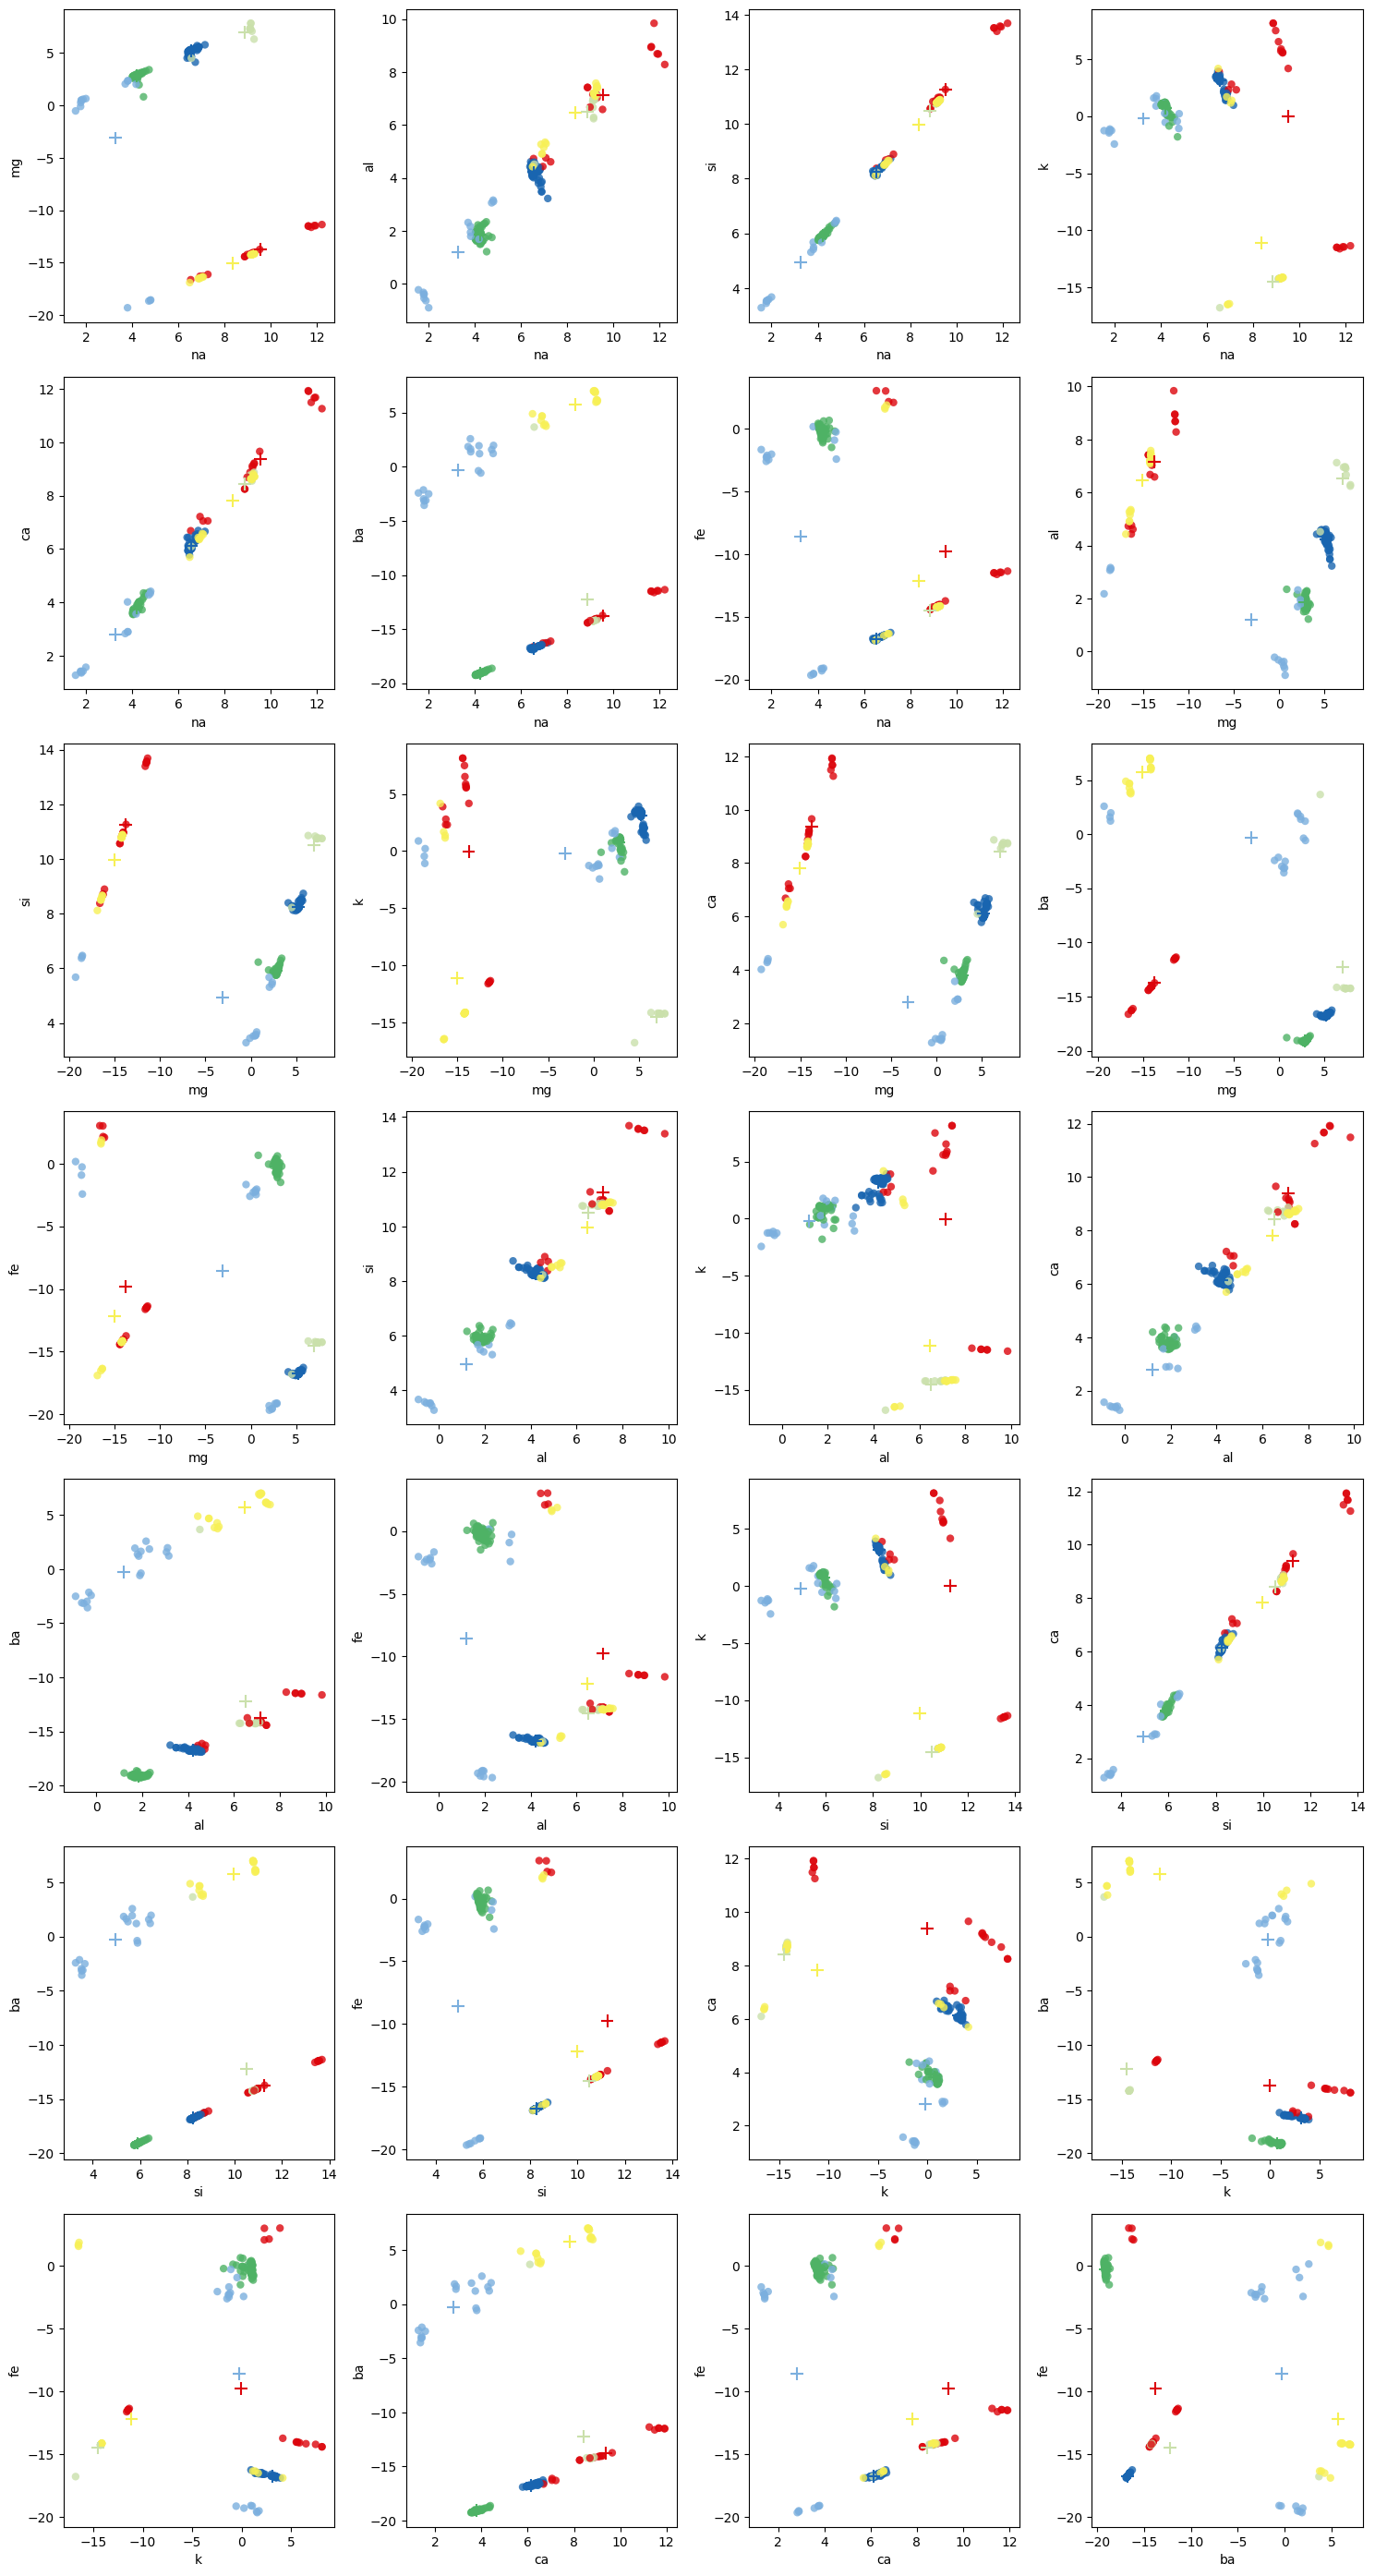

In [ ]:
h.plot_data(X, names, pairs, clKM_labels6, clKM6.cluster_centers_, map_labels6)

## Bisecting k-means clustering

We perform the same pipeline with the bisecting k-means algorithm.

In [ ]:
clBKMn7 = cluster.BisectingKMeans(n_clusters=7, random_state=RS).fit(X)
clBKMn7_labels, map_labels7 = h.relabel_clusters_size(clBKMn7.labels_)
np.bincount(clBKMn7_labels+1)

array([  0, 105,  56,  19,  13,   7,   7,   7])

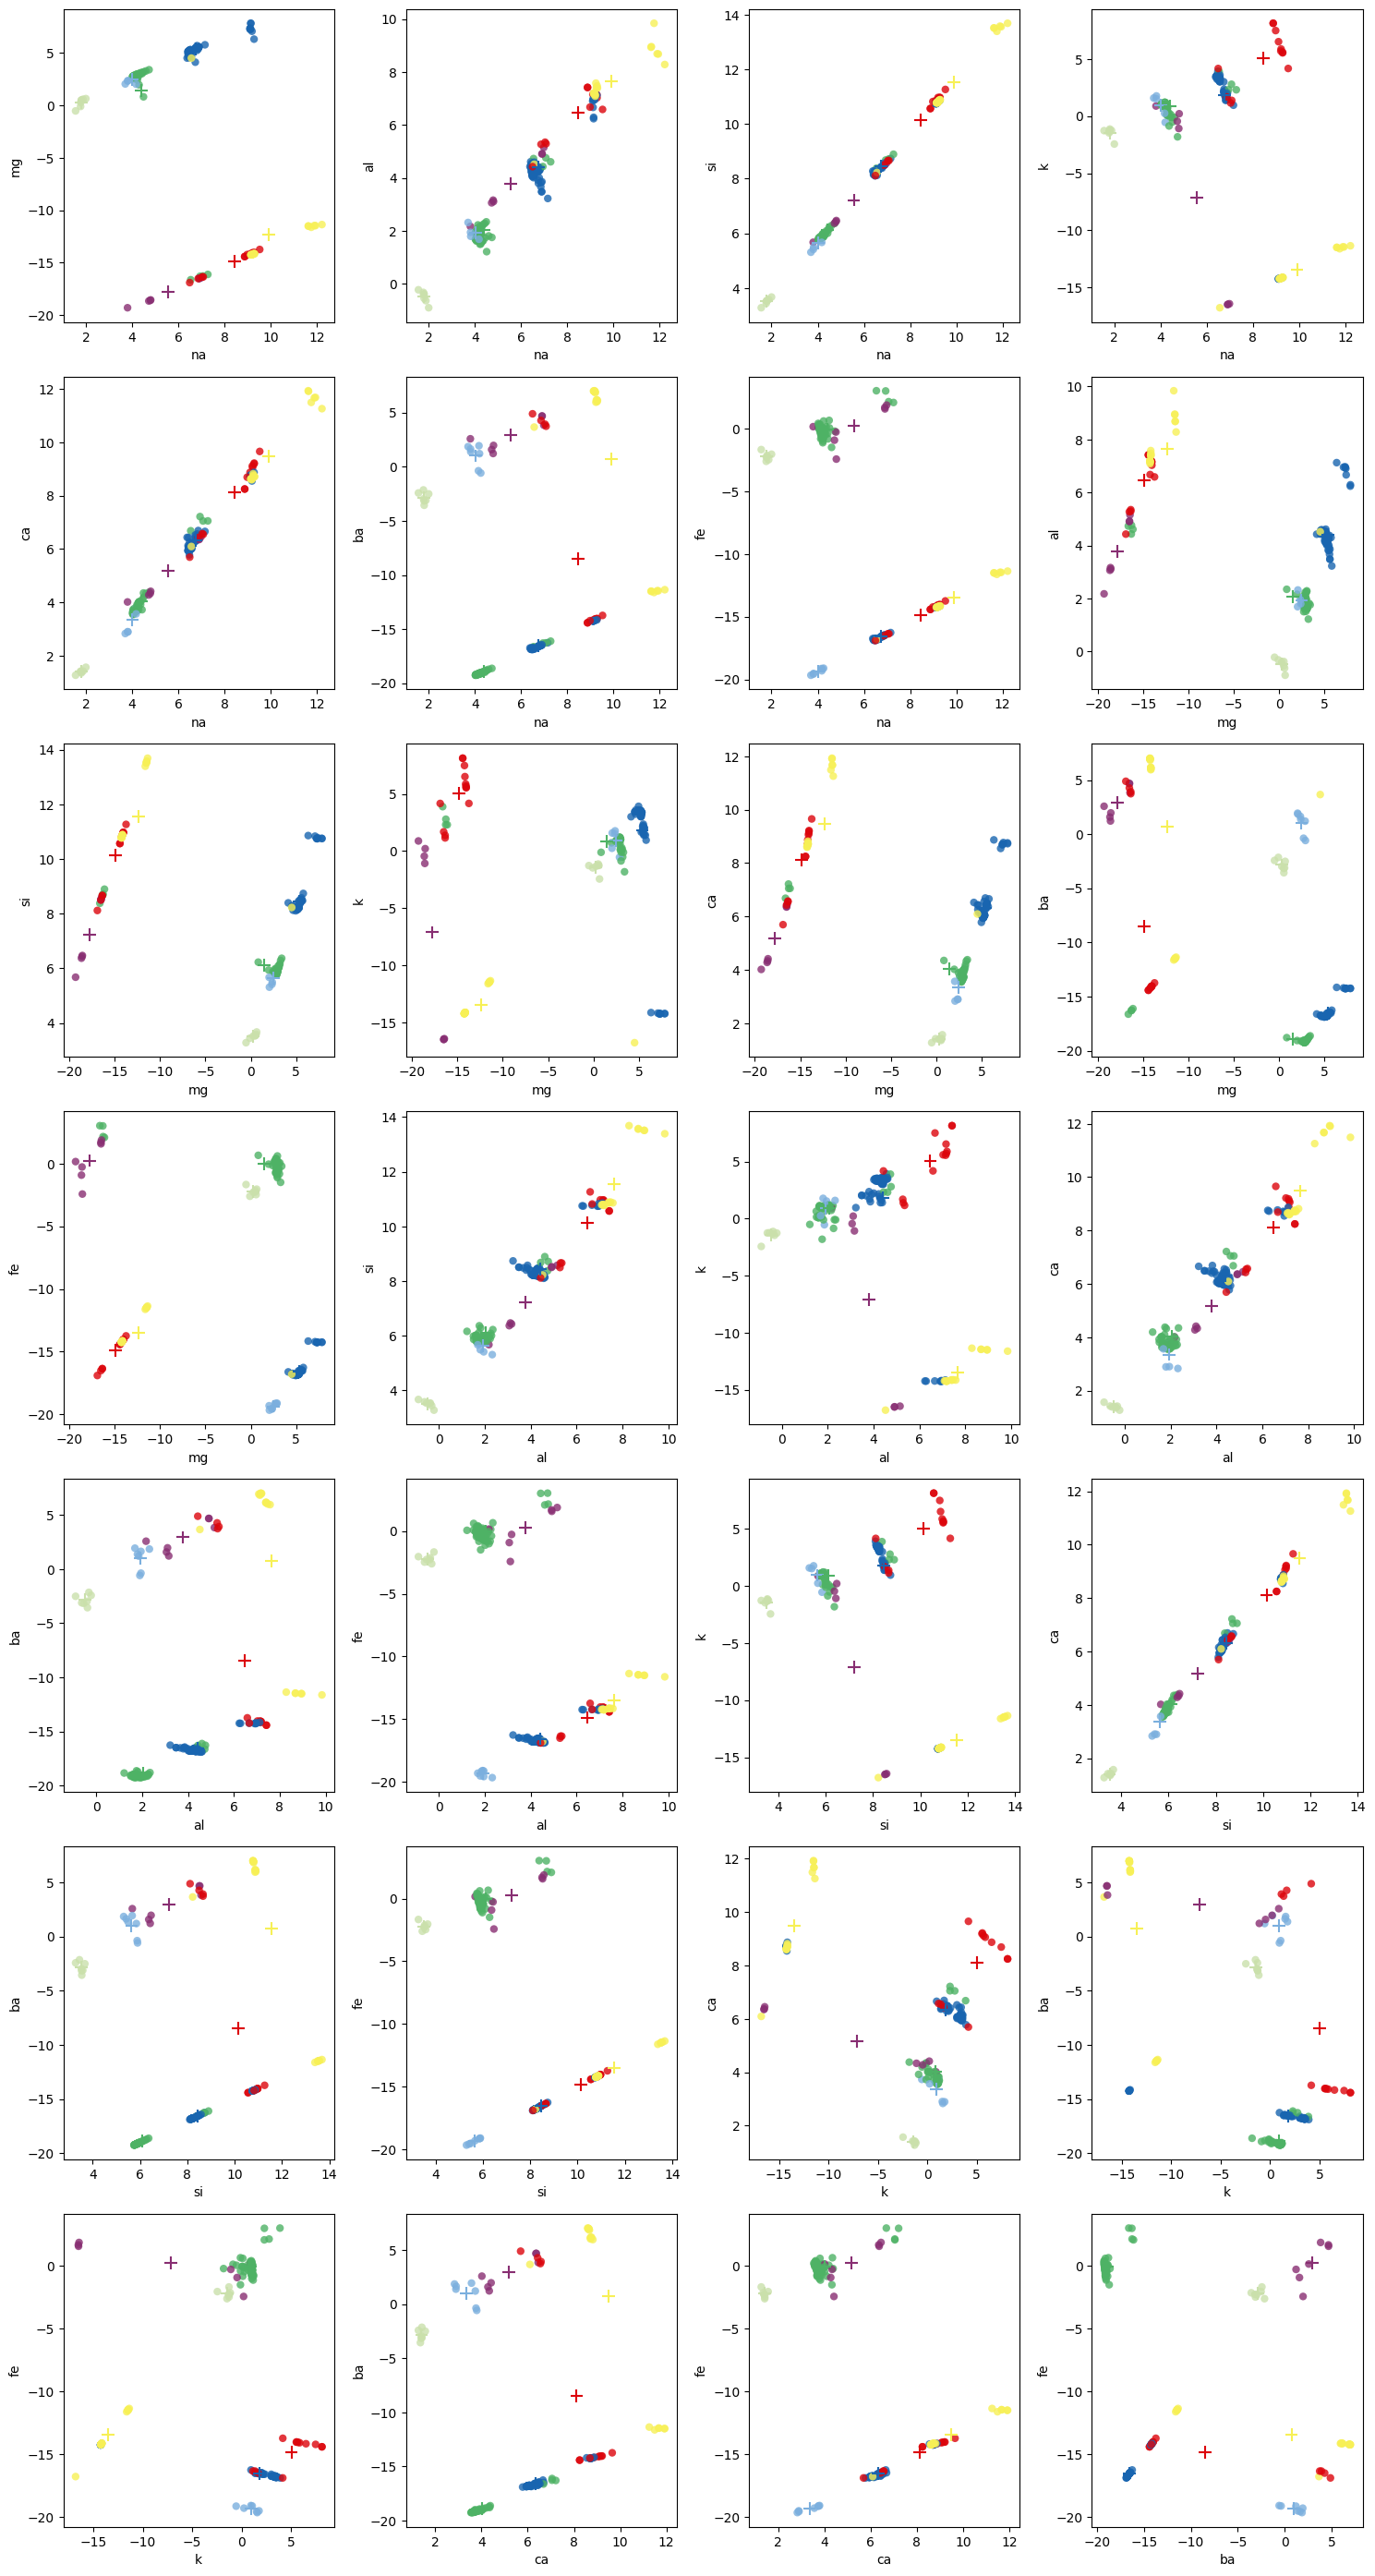

In [ ]:
h.plot_data(X, names, pairs, clBKMn7_labels, clBKMn7.cluster_centers_, map_labels7)

... and for k=6

[ 0 97 59 23 19 15  1]


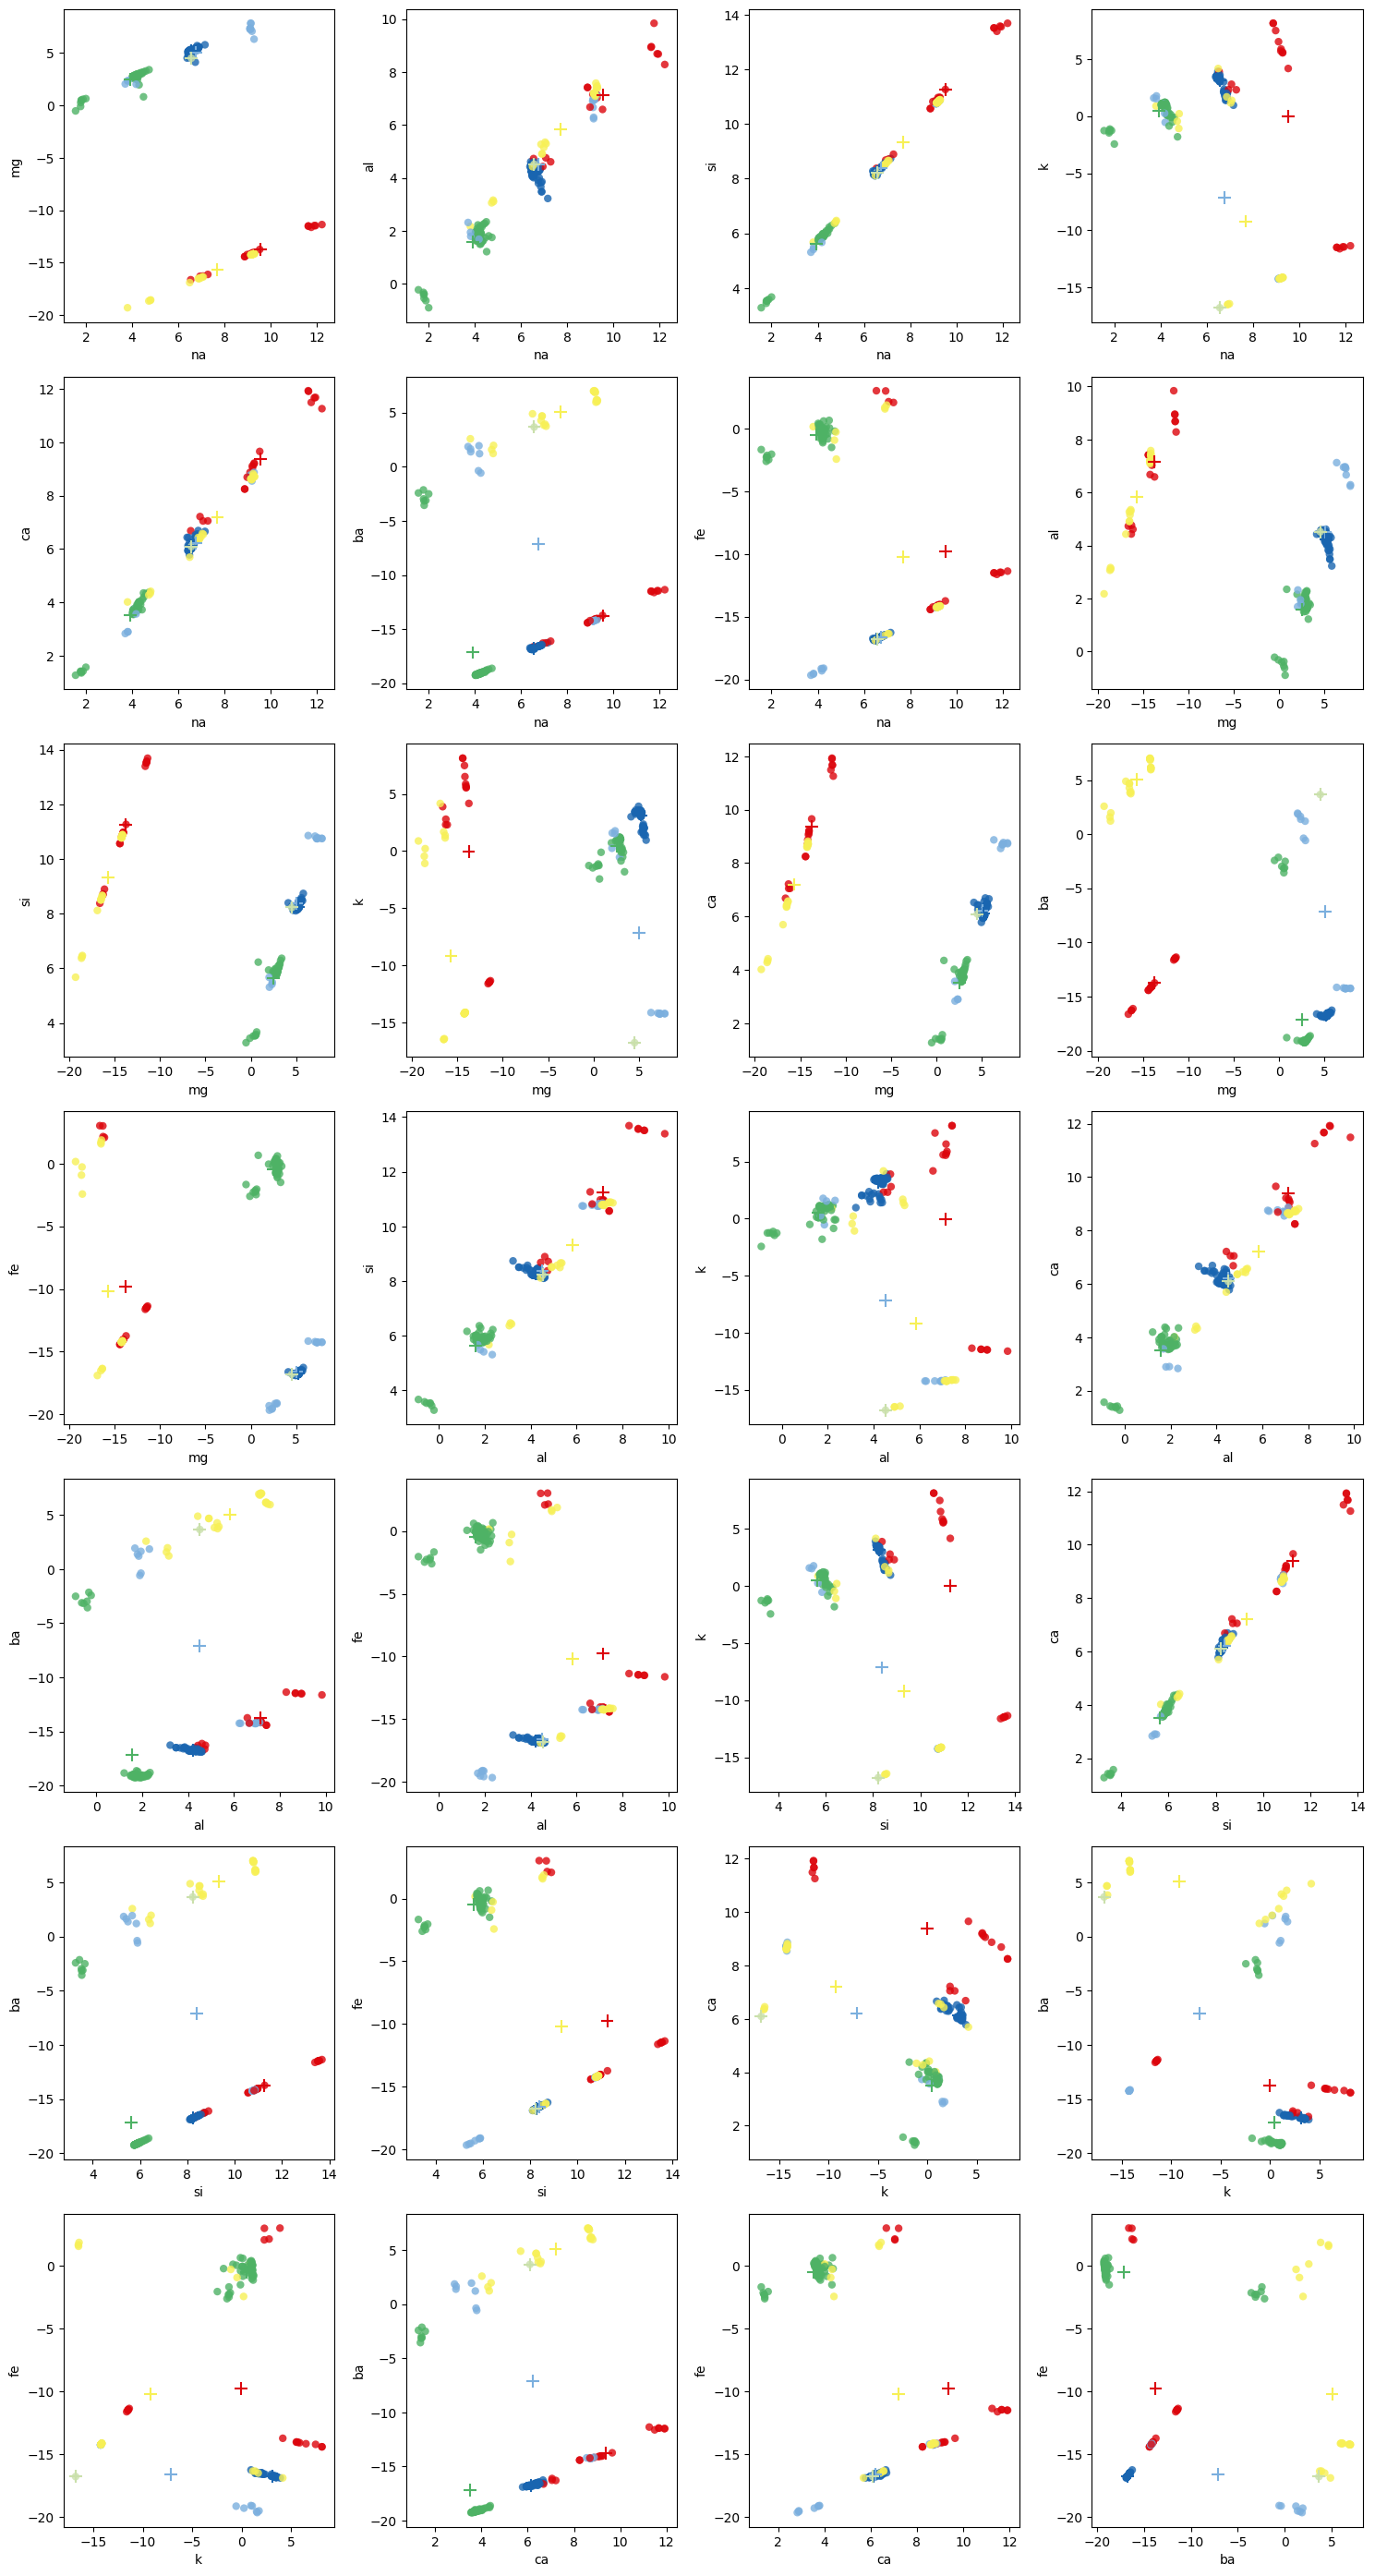

In [ ]:
clBKMn6 = cluster.BisectingKMeans(n_clusters=6, random_state=RS).fit(X)
clBKMn6_labels, map_labels6 = h.relabel_clusters_size(clBKMn6.labels_)

print( np.bincount(clBKMn6_labels+1) )

h.plot_data(X, names, pairs, clBKMn6_labels, clBKMn6.cluster_centers_, map_labels6)

## Agglomerative clustering

As described in the example notebook, different linkage functions define different bottom-up hierarchical algorithms. We are going to use only linkage functions covered in the lecture, namely --- complete, single, and average linkage. Again, for each linkage, we are going to truncate the dendrogram to obtain two clusterings (one containing 7 and one 6 clusters).

### Complete linkage

First, we plot the resulting dendrogram:

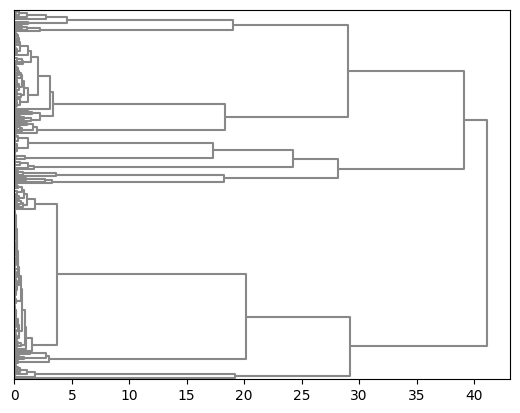

In [ ]:
model = cluster.AgglomerativeClustering(linkage="complete", distance_threshold=0, n_clusters=None).fit(X)
d = h.plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)
plt.show()

Notice that the distance values are relatively high.

Now, we obtain clusterings:

[  0 104  59  15  13   9   8   6]


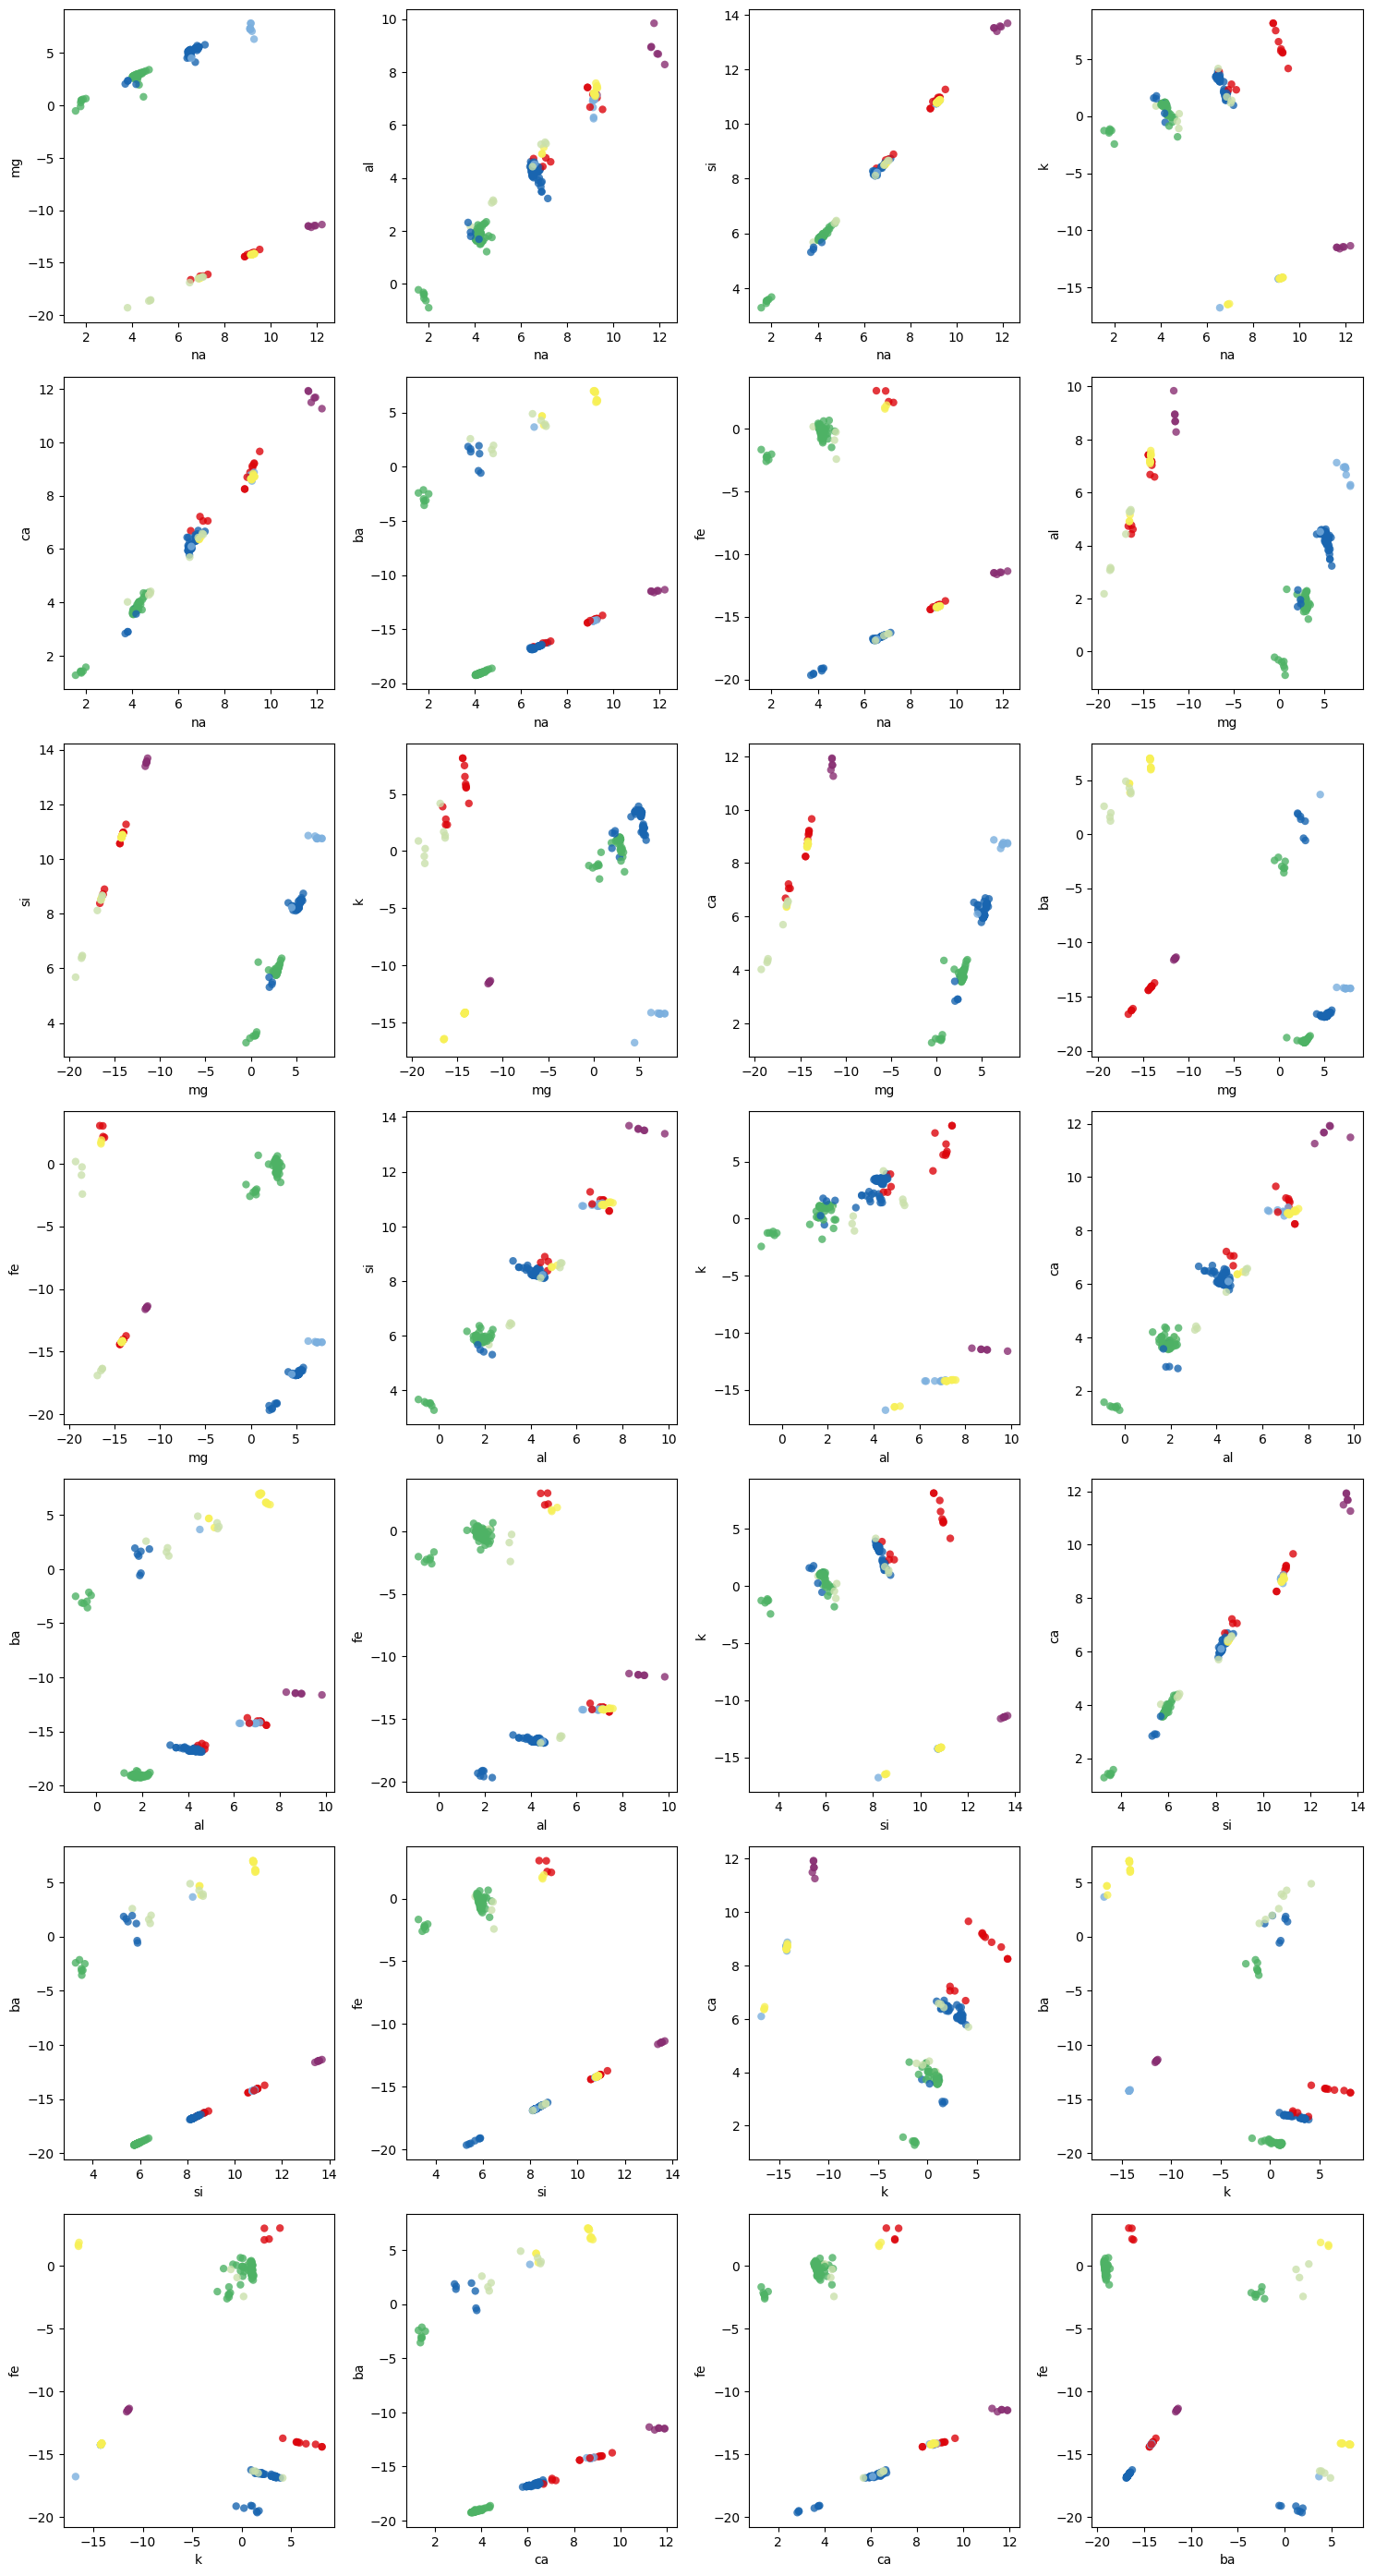

In [ ]:
clAc7 = cluster.AgglomerativeClustering(linkage="complete", n_clusters=7).fit(X)
clAc7_labels, map_labels = h.relabel_clusters_size(clAc7.labels_)

print( np.bincount(clAc7_labels + 1) )

h.plot_data(X, names, pairs, clAc7_labels)

[  0 104  59  21  13   9   8]


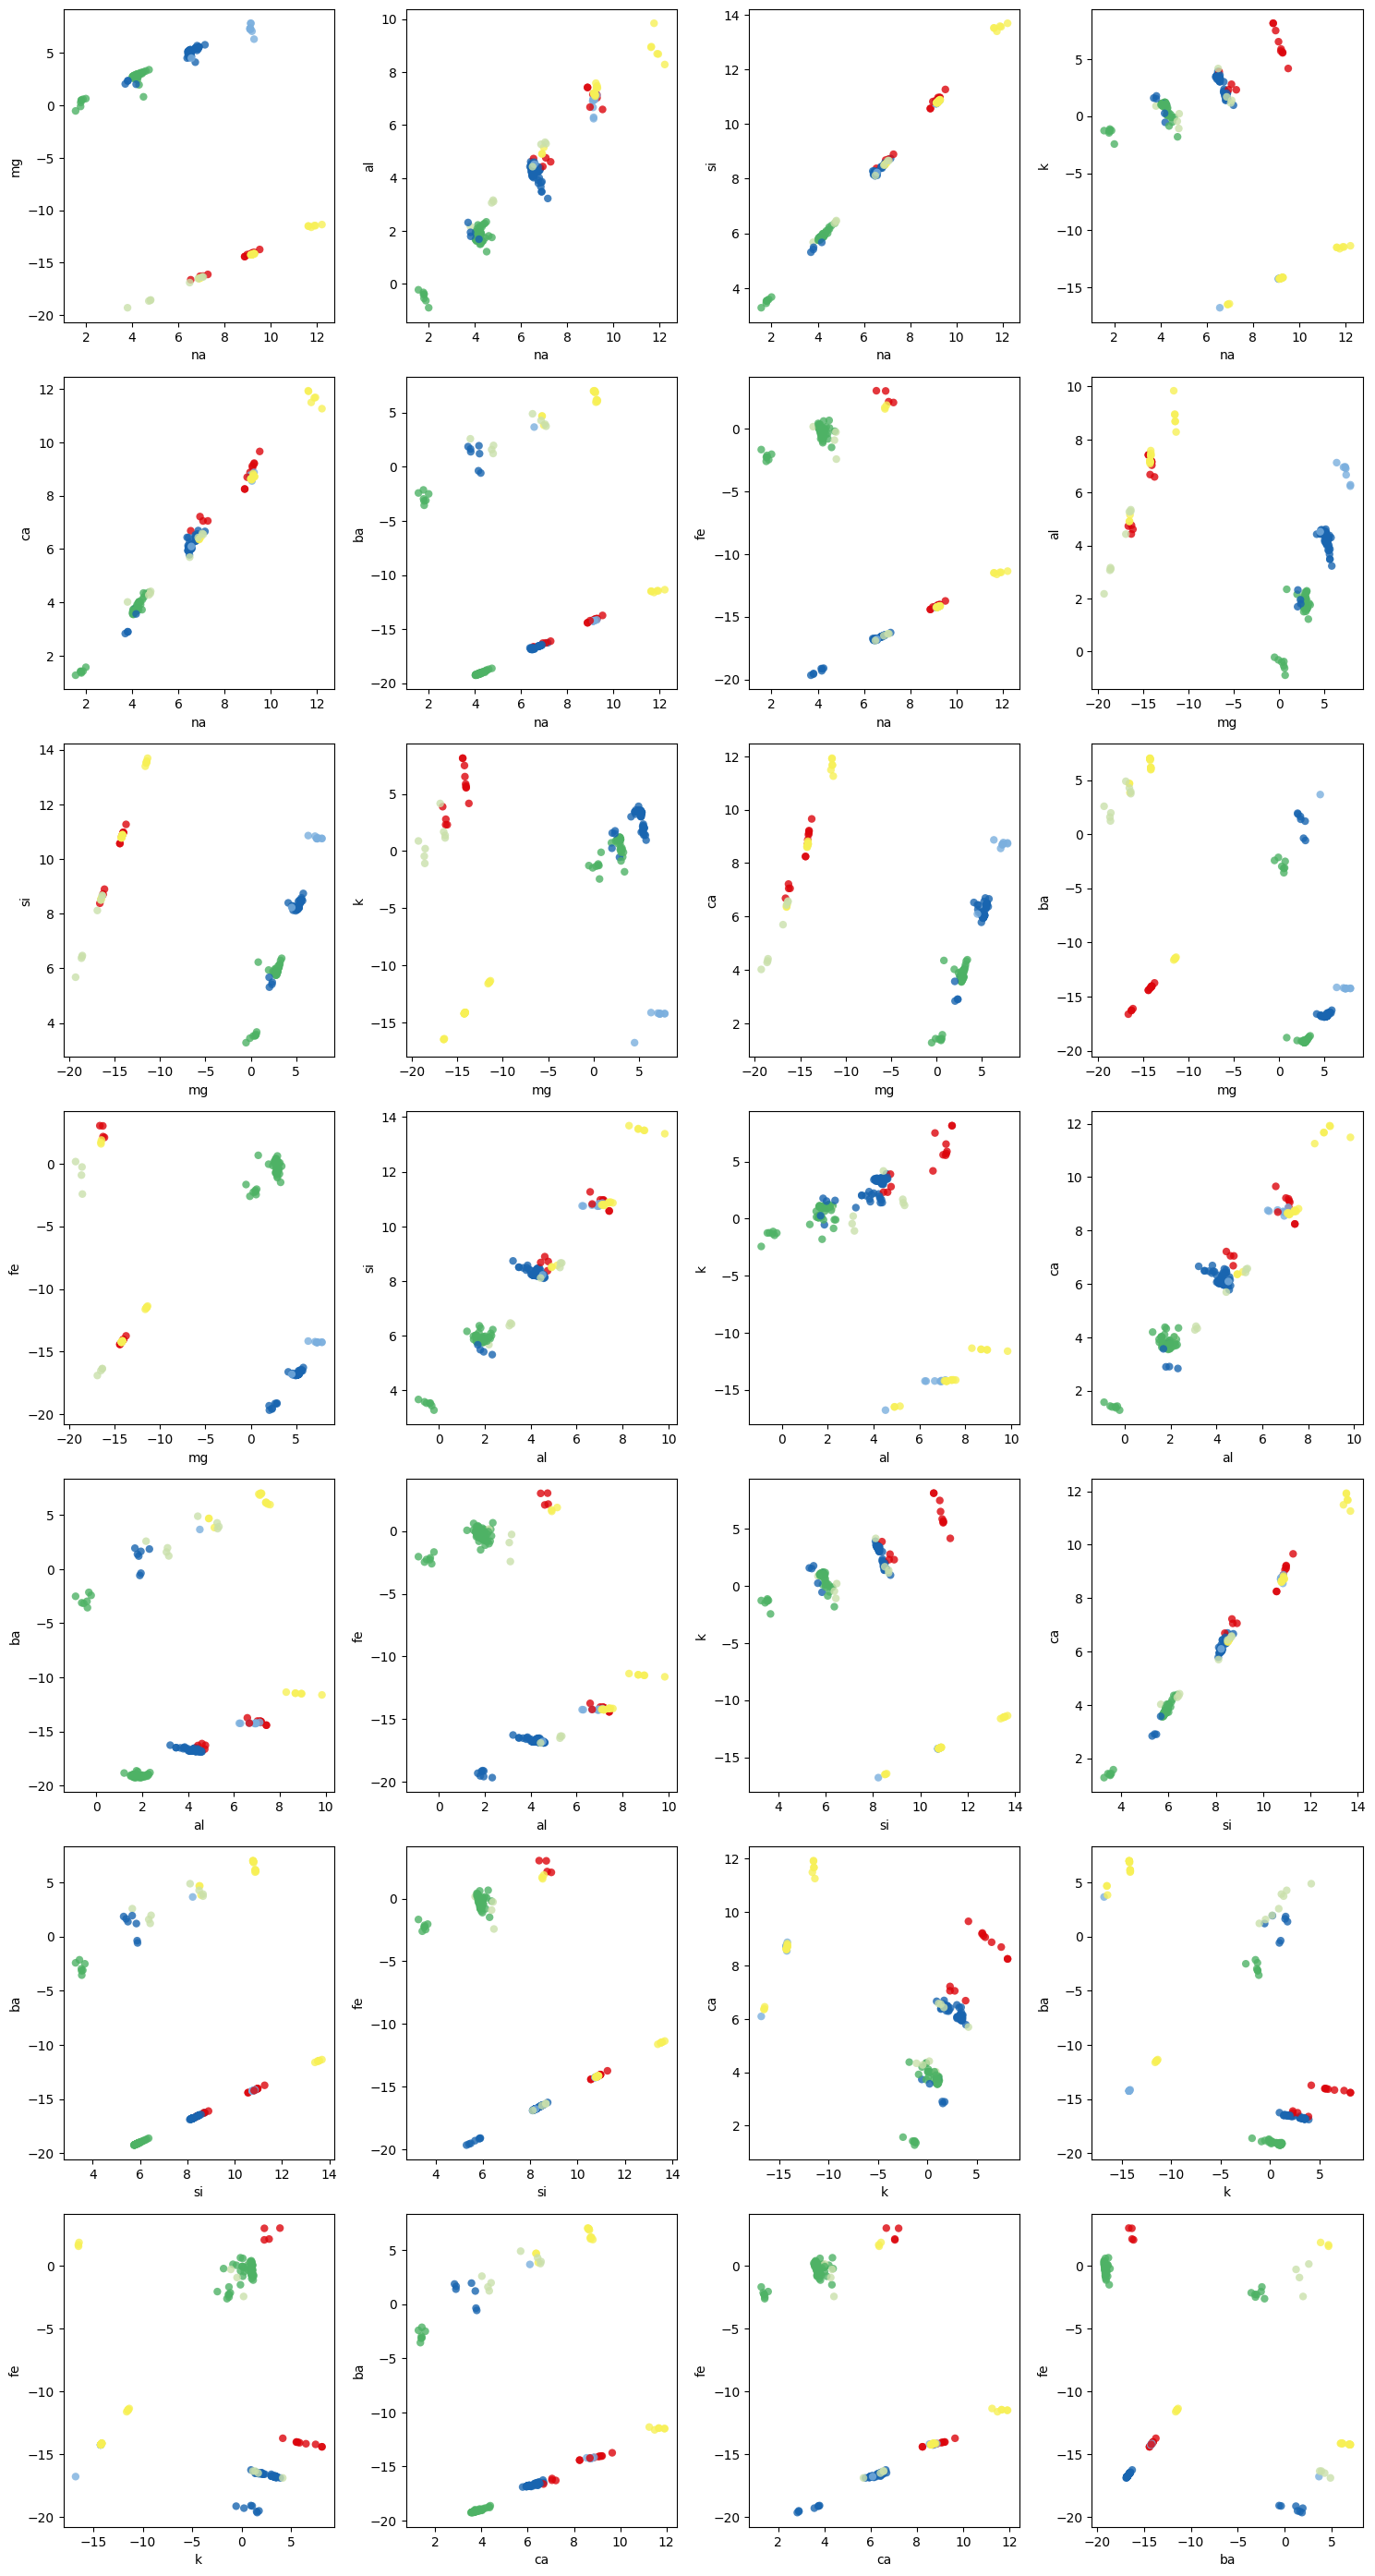

In [ ]:
clAc6 = cluster.AgglomerativeClustering(linkage="complete", n_clusters=6).fit(X)
clAc6_labels, map_labels = h.relabel_clusters_size(clAc6.labels_)

print( np.bincount(clAc6_labels + 1) )

h.plot_data(X, names, pairs, clAc6_labels)

Again, it is difficult to judge how the clustering went since our data are high-dimensional, and thus, it is hard to see the clusters visually.

### Single linkage

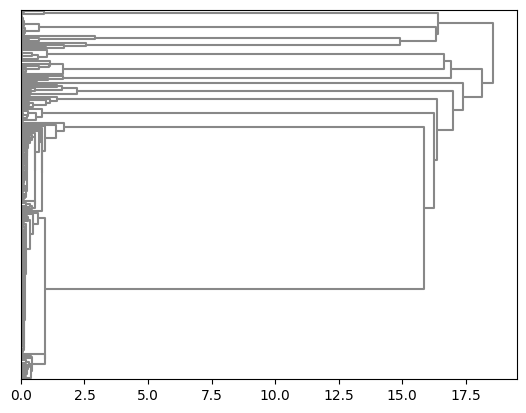

In [ ]:
model = cluster.AgglomerativeClustering(linkage="single", distance_threshold=0, n_clusters=None).fit(X)
d = h.plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)
plt.show()

For the single linkage, we see that the dendrogram is leaning to the left side (we made this observation also in the example notebook).

[  0 164  23   9   7   6   4   1]


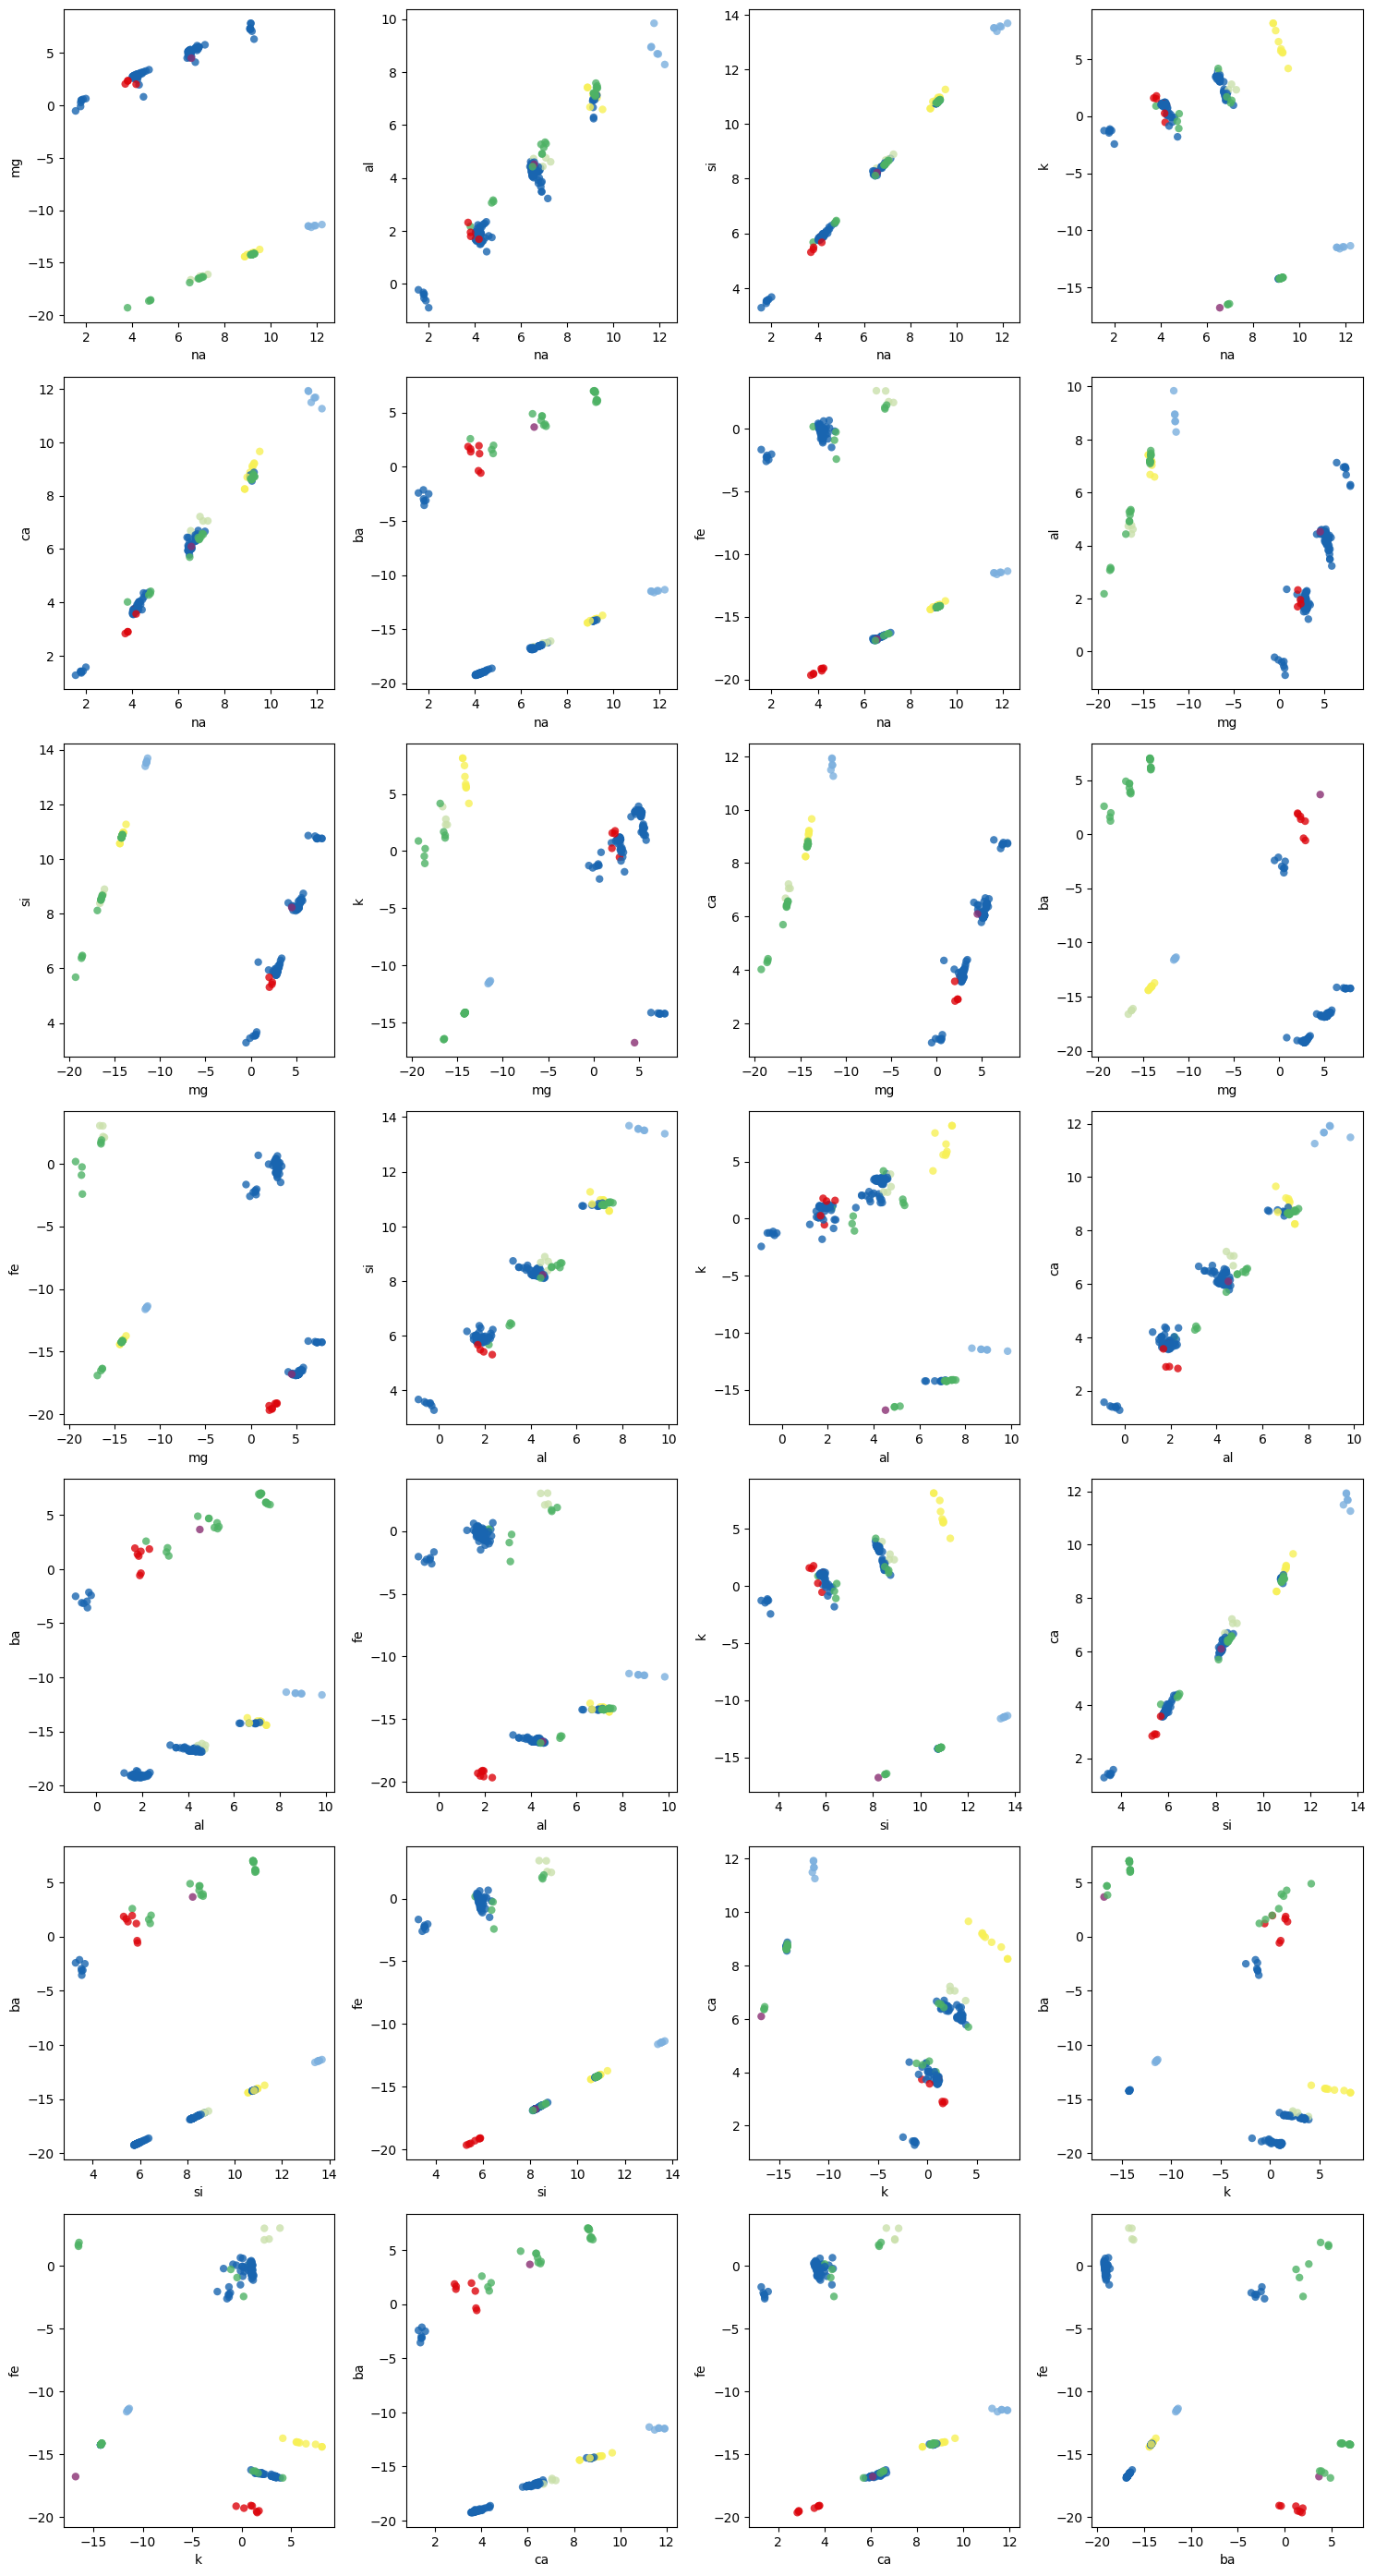

In [ ]:
clAs7 = cluster.AgglomerativeClustering(linkage="single", n_clusters=7).fit(X)
clAs7_labels, map_labels = h.relabel_clusters_size(clAs7.labels_)

print( np.bincount(clAs7_labels + 1) )

h.plot_data(X, names, pairs, clAs7_labels)

[  0 164  23  15   7   4   1]


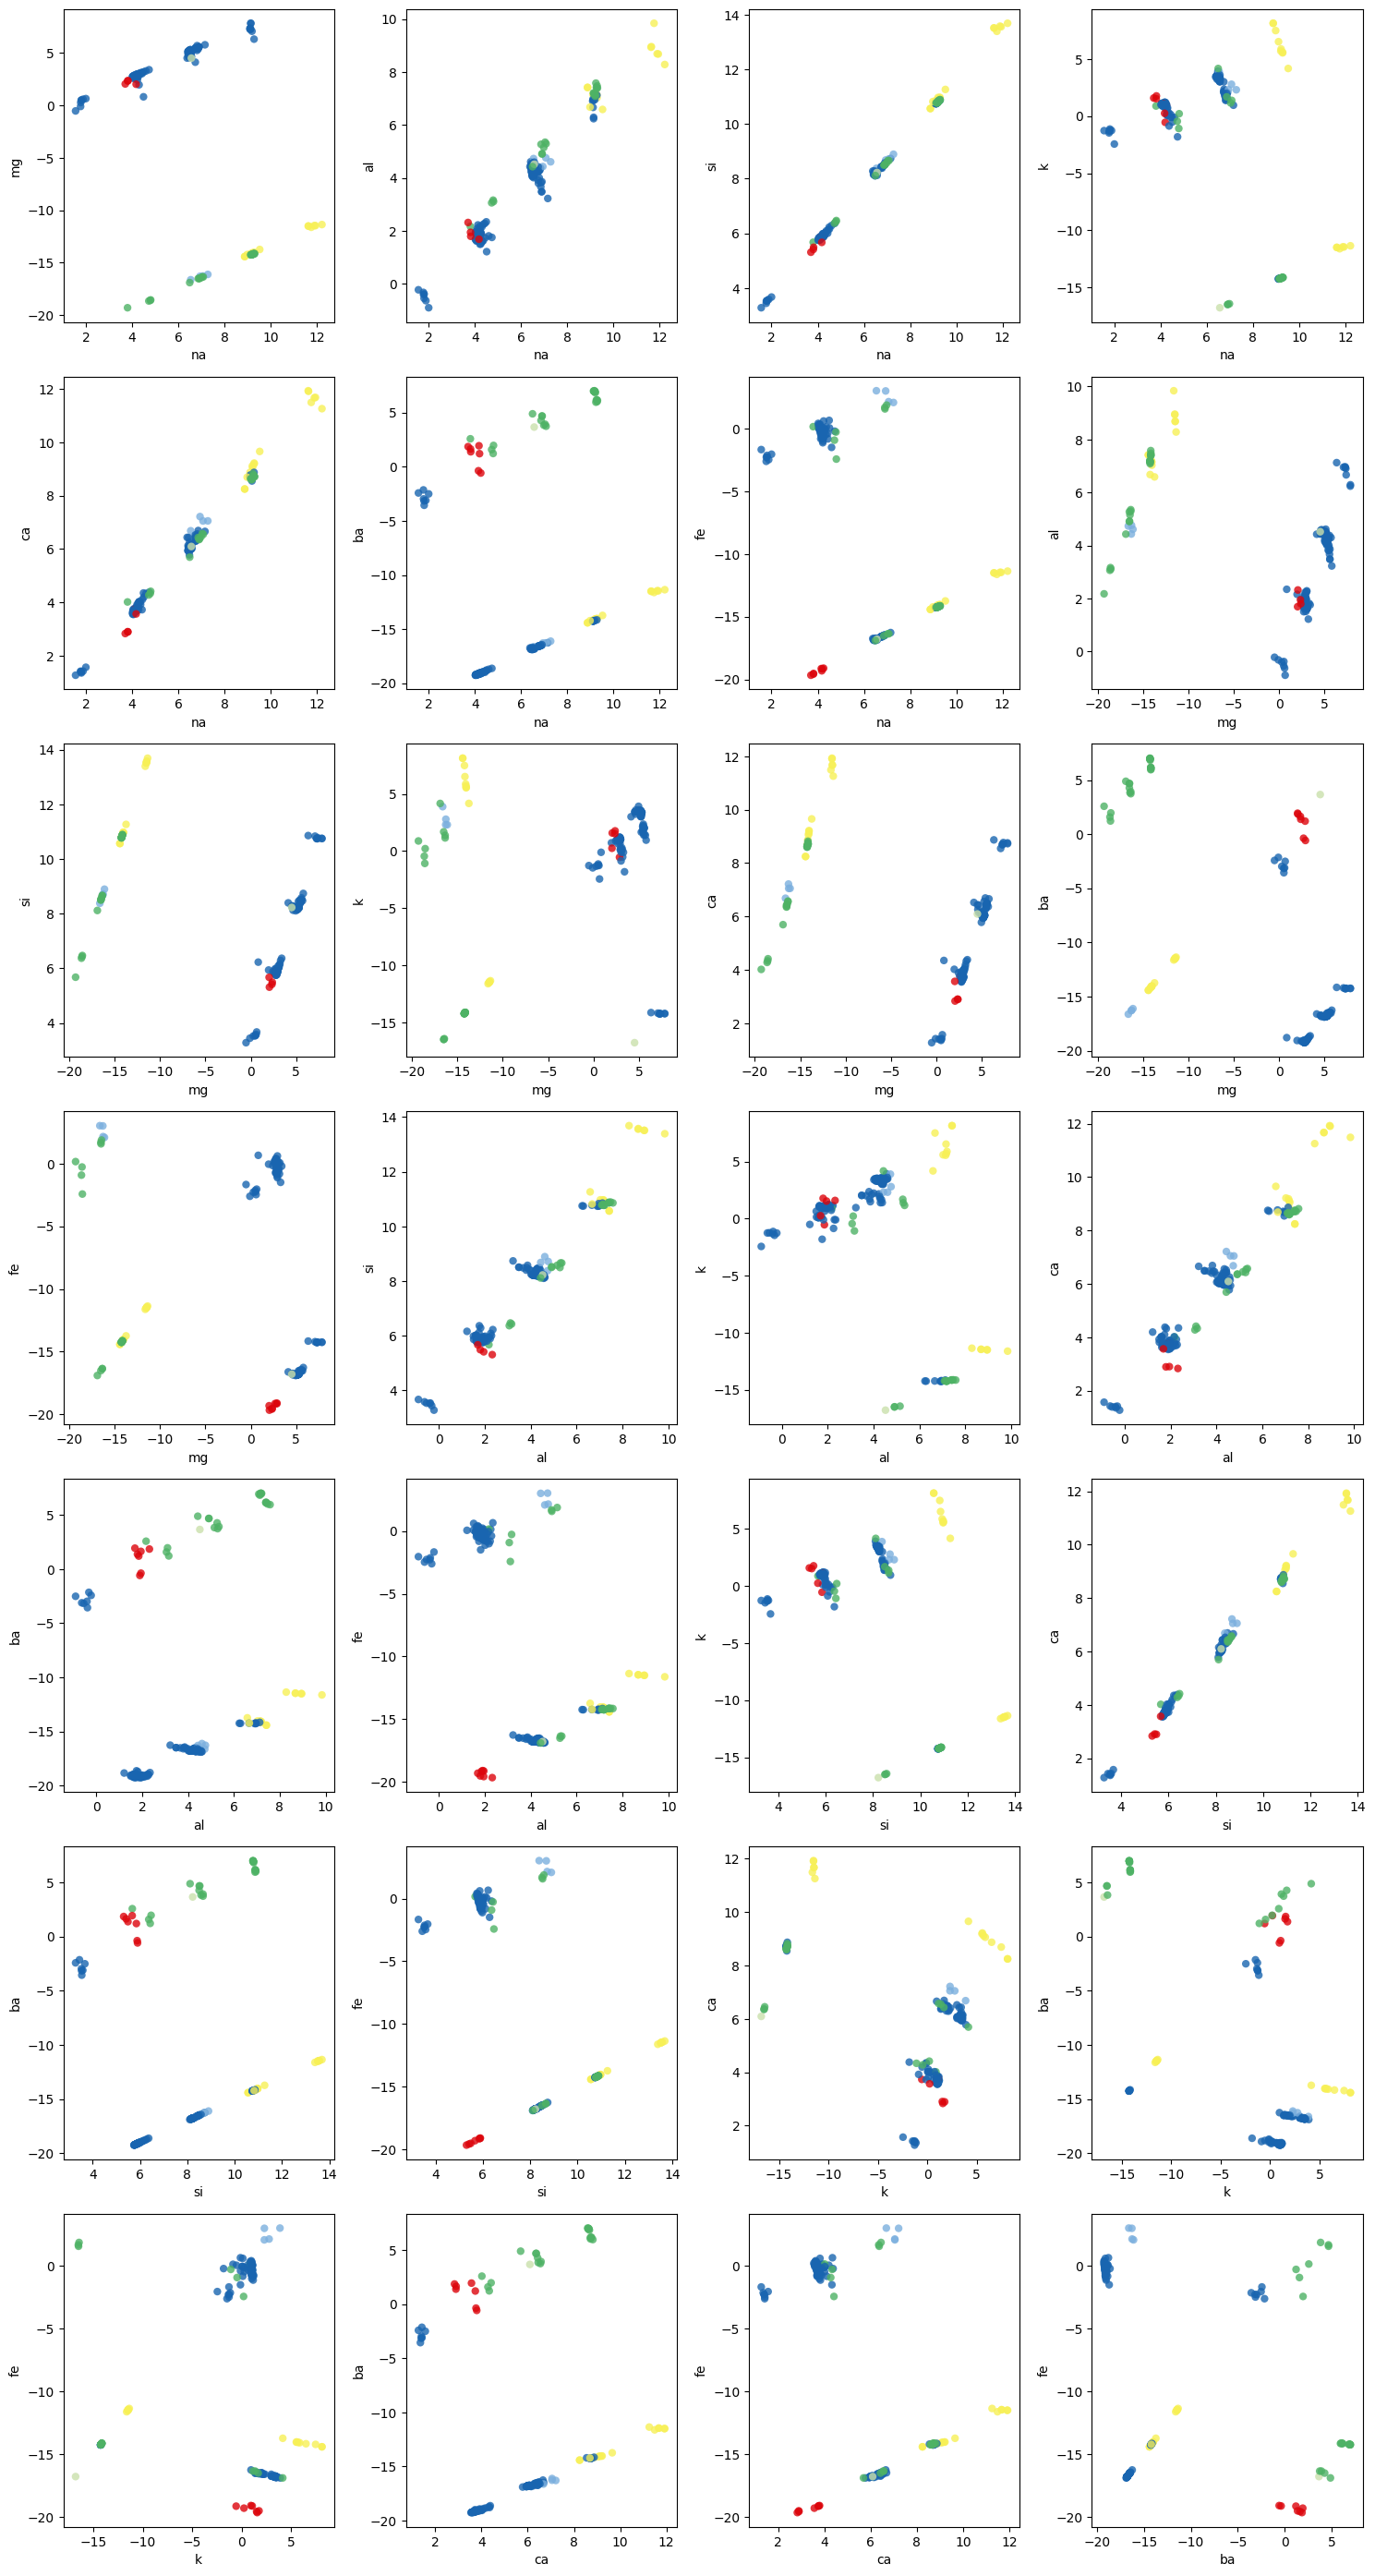

In [ ]:
clAs6 = cluster.AgglomerativeClustering(linkage="single", n_clusters=6).fit(X)
clAs6_labels, map_labels = h.relabel_clusters_size(clAs6.labels_)

print( np.bincount(clAs6_labels + 1) )

h.plot_data(X, names, pairs, clAs6_labels)

Based on the number of samples in each cluster, we observe similar behaviour of single linkage as in the example notebook. Namely, we see that the samples are merged almost one by one to the successive clusters, which results in imbalanced clustering.

### Average linkage

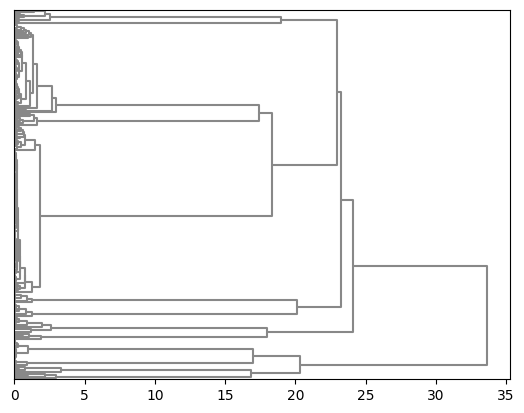

In [ ]:
model = cluster.AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters=None).fit(X)
d = h.plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)
plt.show()

[  0 156  15  13   8   8   8   6]


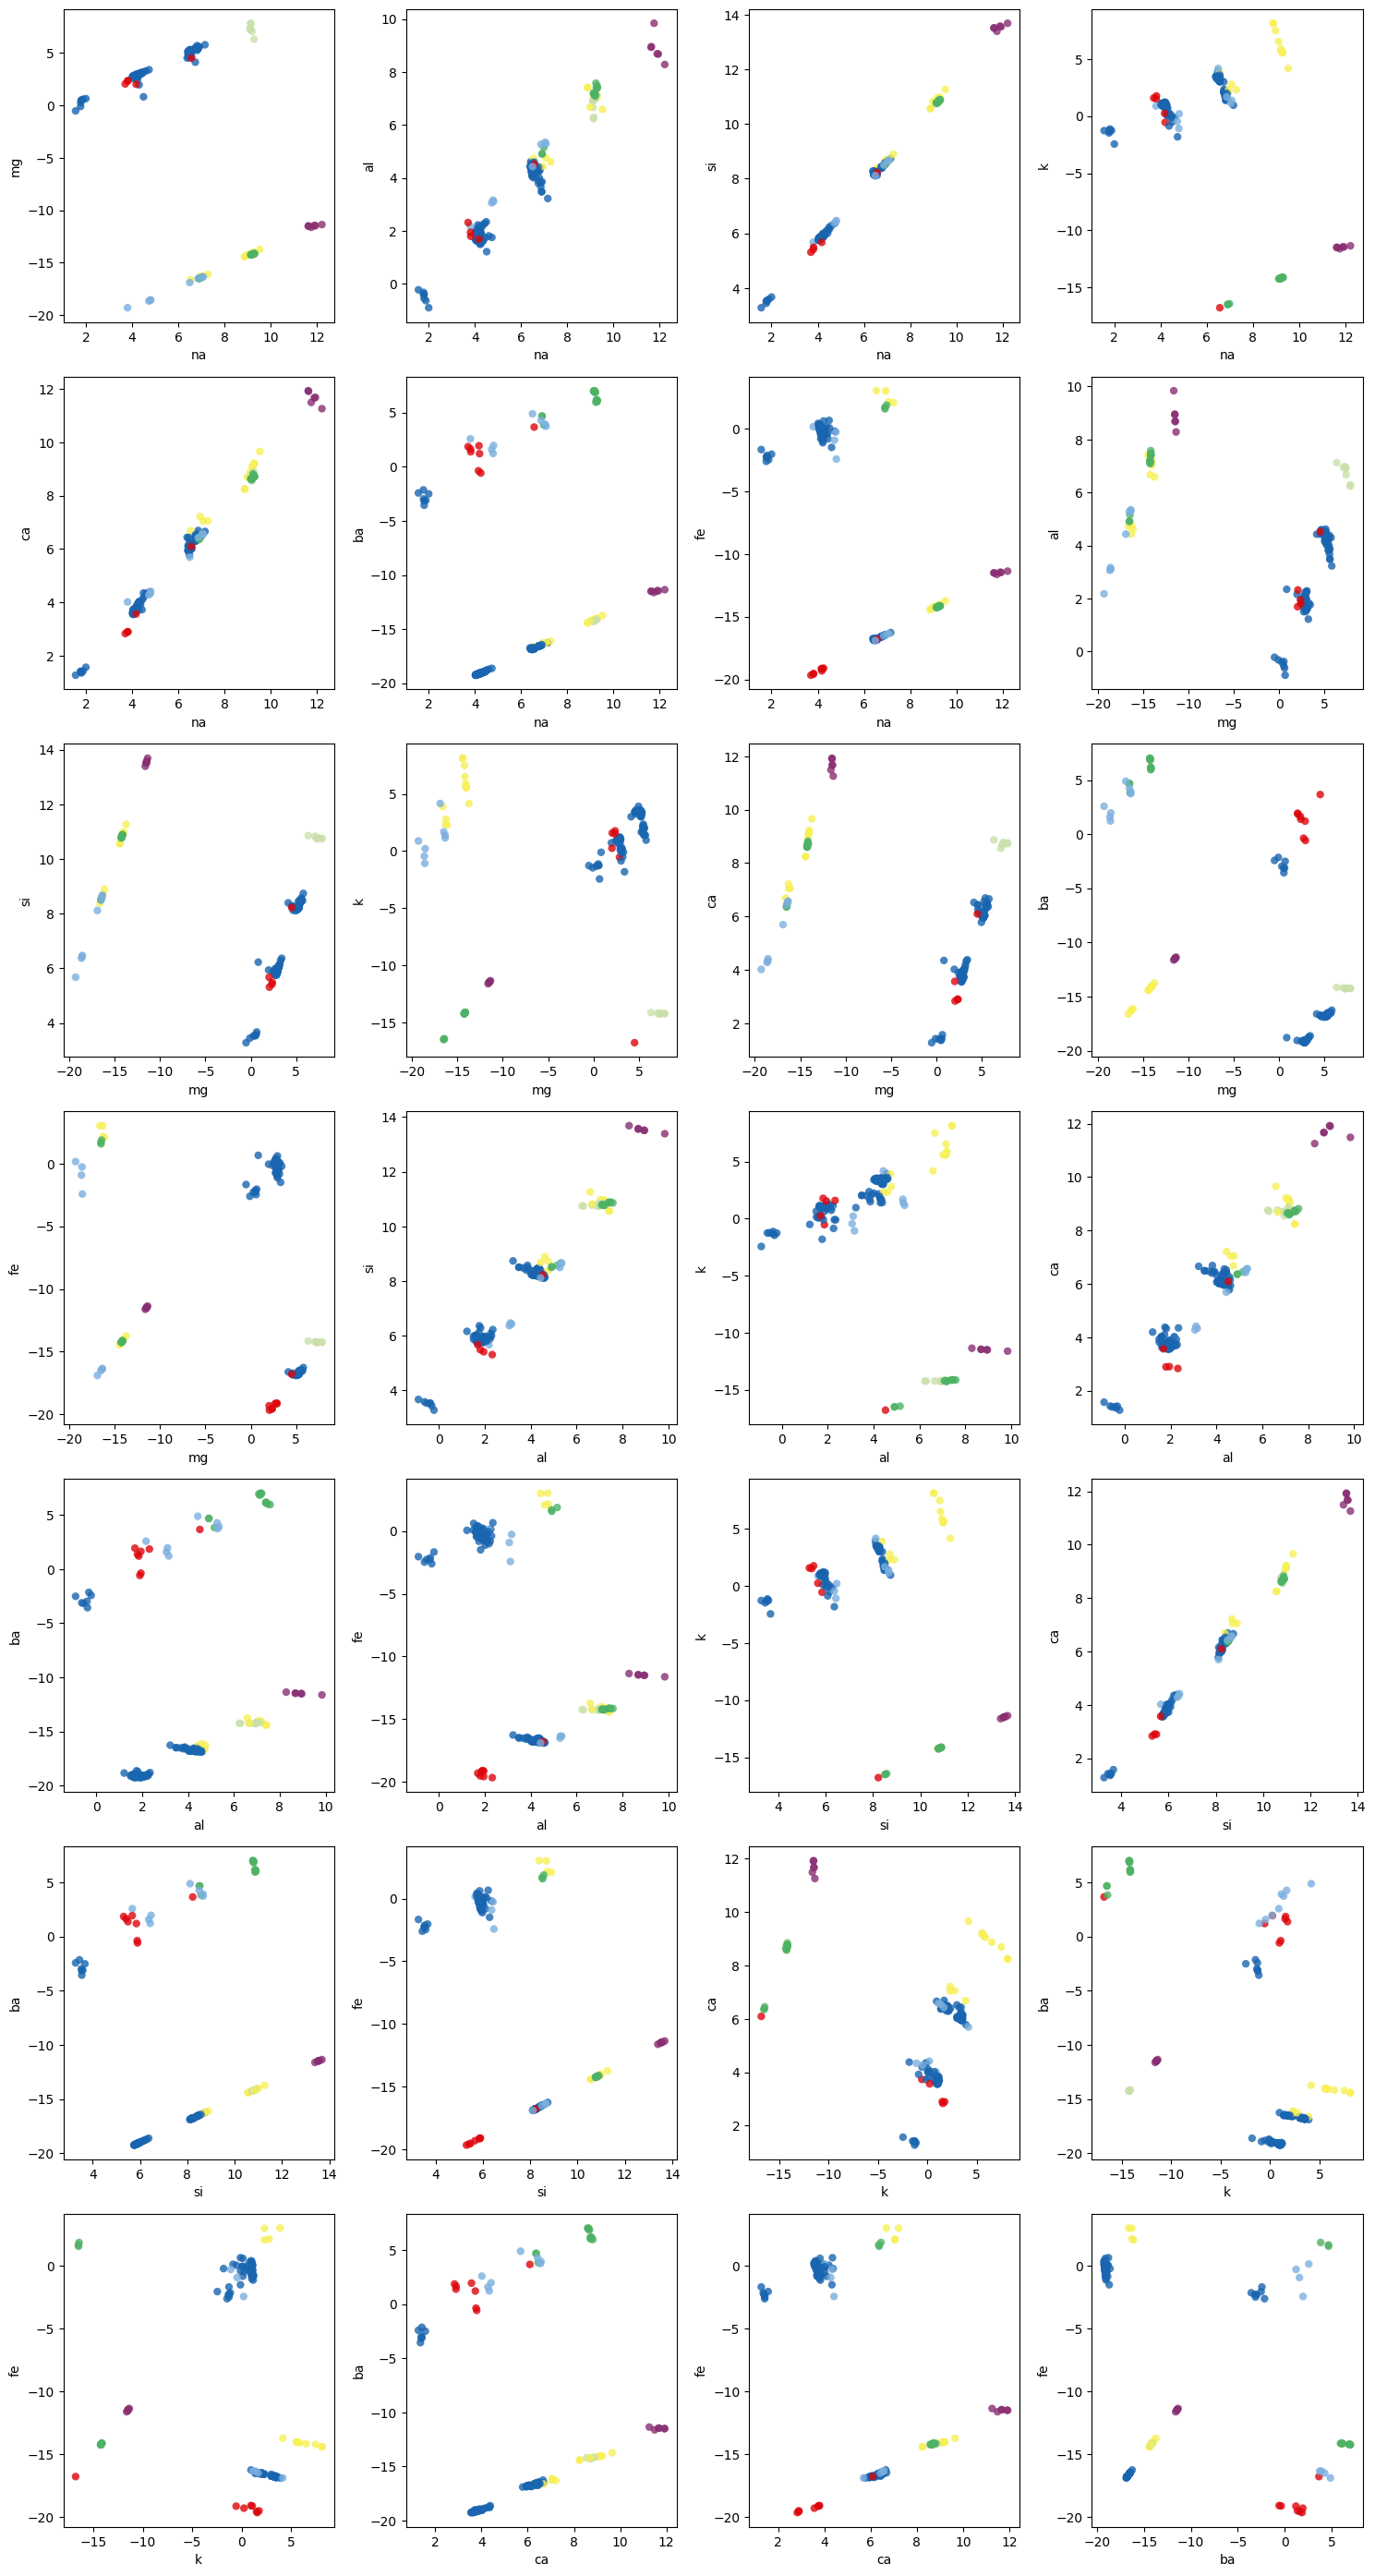

In [ ]:
clAa7 = cluster.AgglomerativeClustering(linkage="average", n_clusters=7).fit(X)
clAa7_labels, map_labels = h.relabel_clusters_size(clAa7.labels_)

print( np.bincount(clAa7_labels + 1) )

h.plot_data(X, names, pairs, clAa7_labels)

[  0 156  15  14  13   8   8]


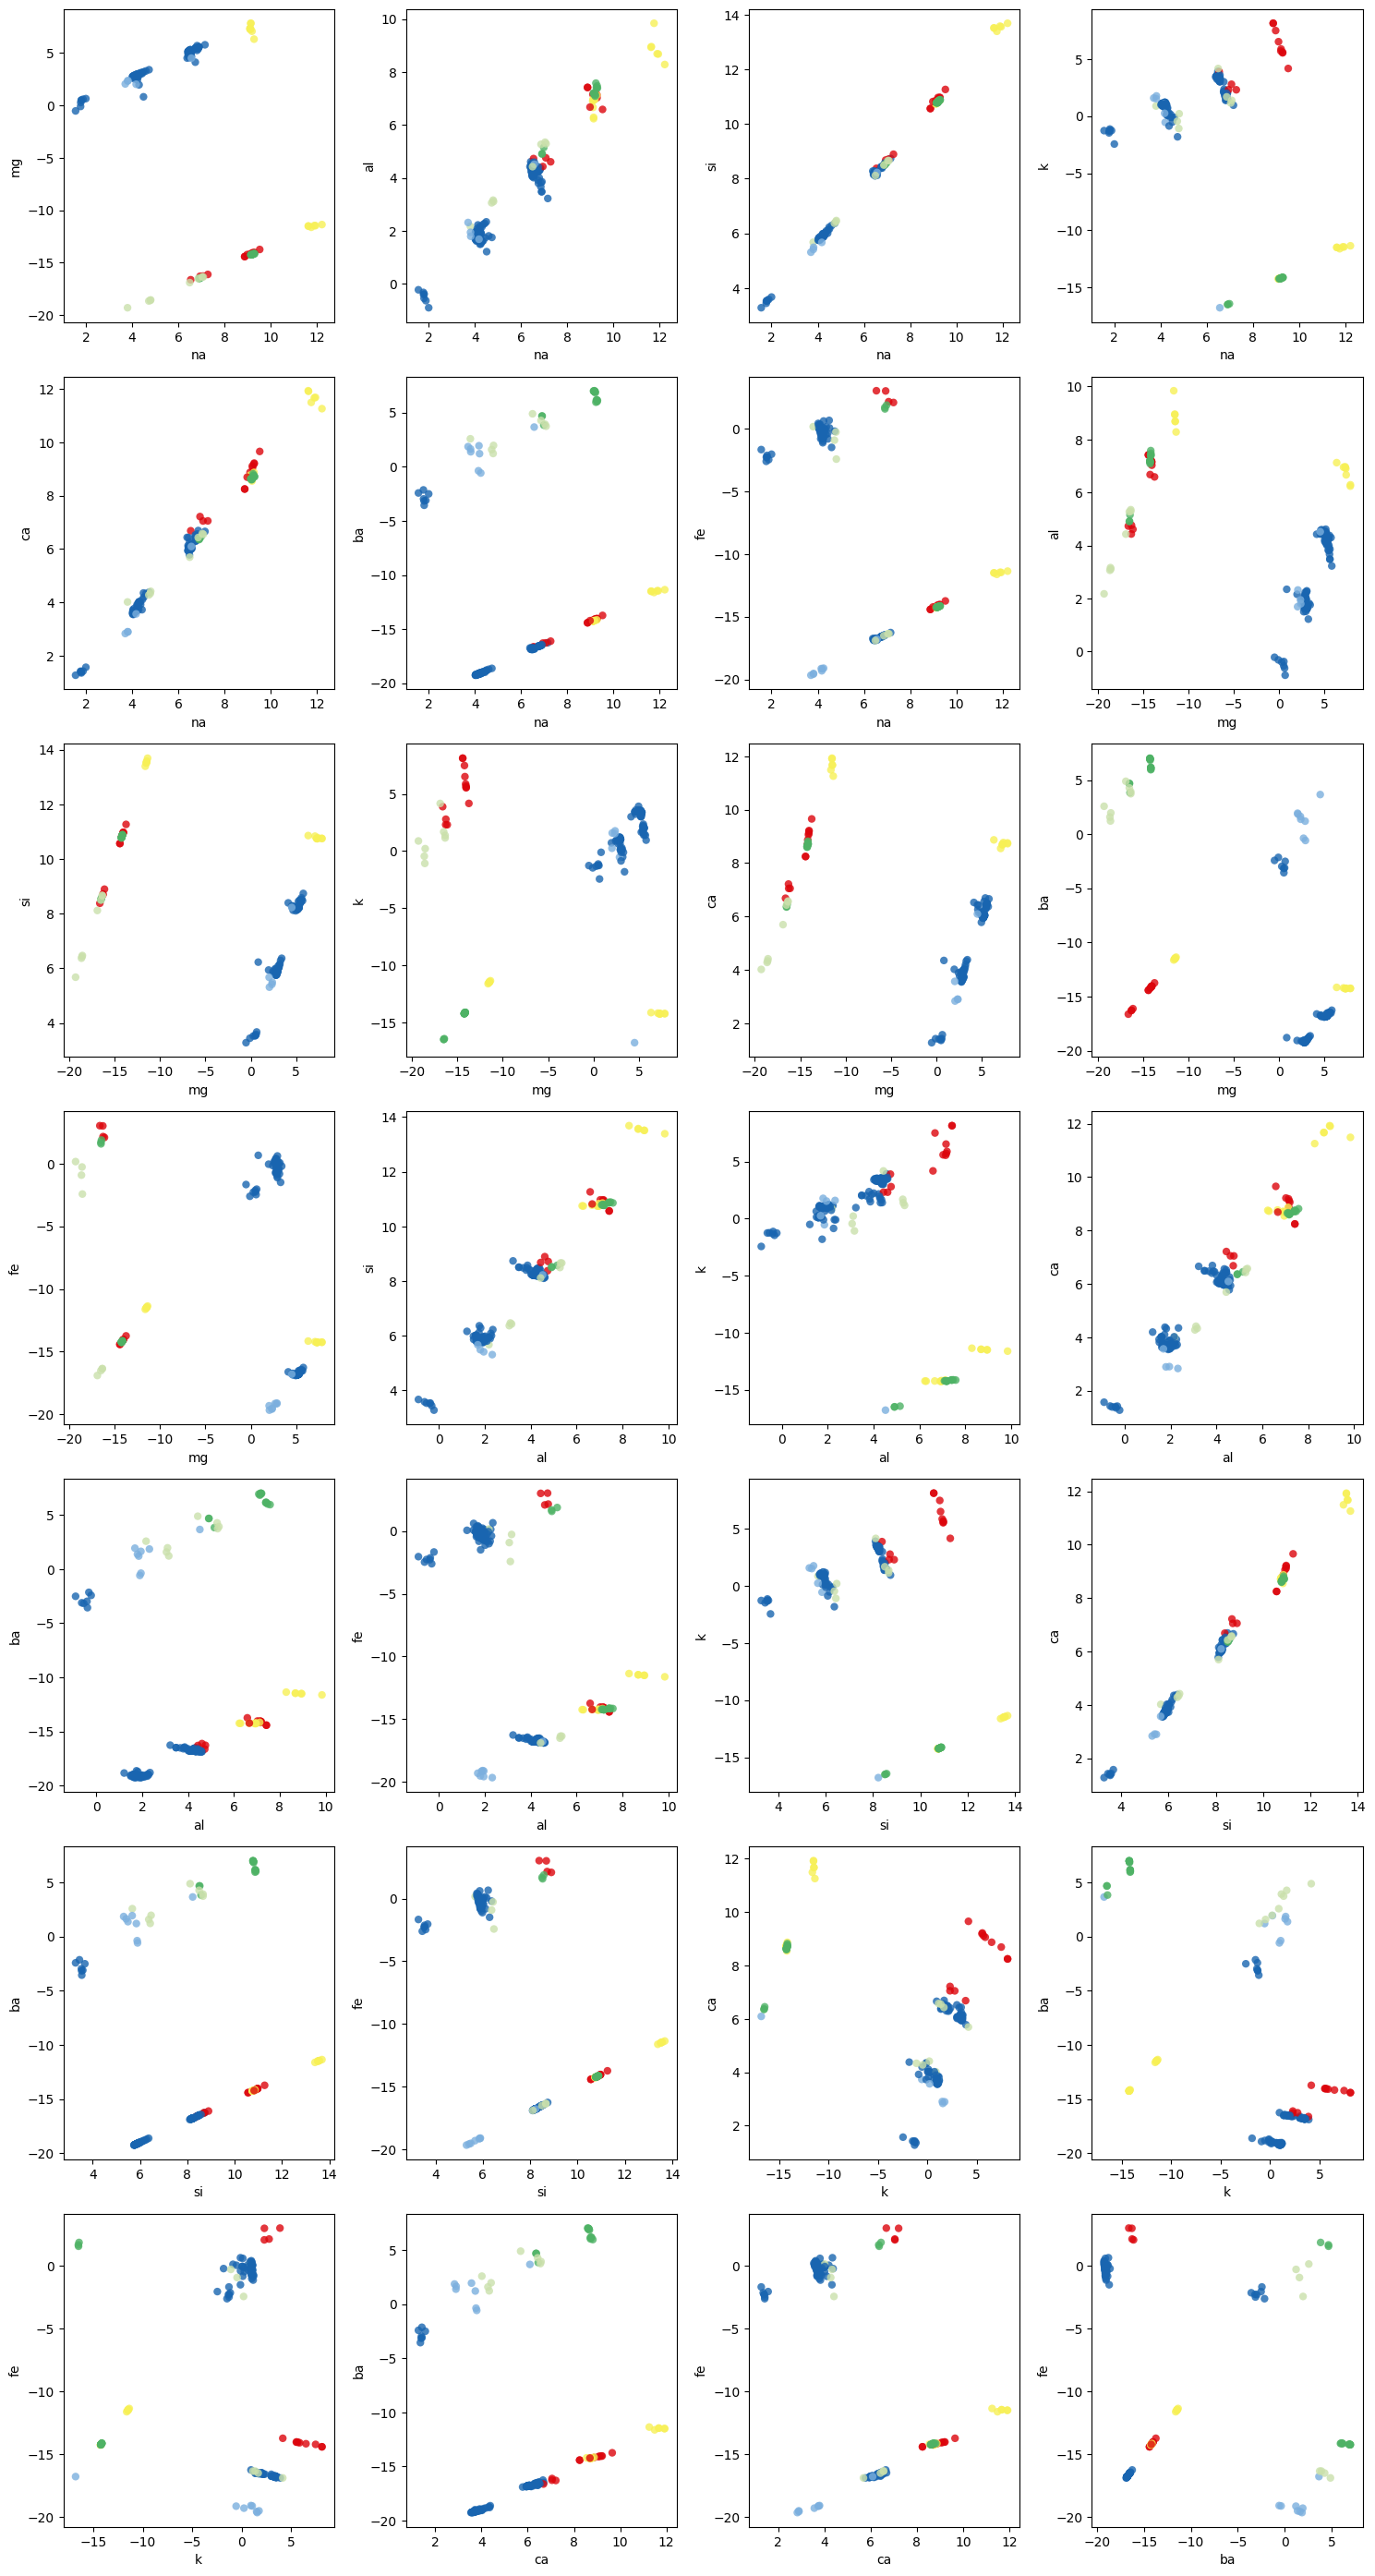

In [ ]:
clAa6 = cluster.AgglomerativeClustering(linkage="average", n_clusters=6).fit(X)
clAa6_labels, map_labels = h.relabel_clusters_size(clAa6.labels_)

print( np.bincount(clAa6_labels + 1) )

h.plot_data(X, names, pairs, clAa6_labels)

For the average linkage, we also observe one huge cluster while the rest being very small.

## DBSCAN clustering

As the last method for clustering, we used density-based approach --- DBSCAN algorithm.

The biggest trouble with the DBSCAN alogorithm is to find proper values for its parameters, since they strongly depend on specifics of each dataset. By trial and error, we found out that reasonable values are (2, 6) for epsilon and tau respectively. Of course, we could try grid search hyper-parameter search or similar hyper-parameter tuning method (the best parameters would be decided based on cohesiveness of produced clusters for instance).

As a demonstration, we can run the algorithm with several parameter values and observe its behaviour:

In [ ]:
for eps in [0.1, 0.5, 1, 2, 3]:
    for tau in [1, 2, 3, 4, 5, 6]:
        clDBS7 = cluster.DBSCAN(eps=eps, min_samples=tau).fit(X)
        clDBS7_labels, map_labels = h.relabel_clusters_size(clDBS7.labels_)

        print(f"eps={eps}  tau={tau}")
        print("---")
        print( np.bincount(clDBS7_labels+1) )
        print("---")

eps=0.1  tau=1
---
[ 0 64  6  3  3  3  3  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1]
---
eps=0.1  tau=2
---
[114  64   6   3   3   3   3   2   2   2   2   2   2   2   2   2]
---
eps=0.1  tau=3
---
[132  64   6   3   3   3   3]
---
eps=0.1  tau=4
---
[145  63   6]
---
eps=0.1  tau=5
---
[145  63   6]
---
eps=0.1  tau=6
---
[147  61   6]
---
eps=0.5  tau=1
---
[ 0 81 38 14  7  5  5  5  4  4  4  2  2  2  2  2  2  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
---
eps=0.5  tau=2
---
[35 81 38 14  7  5  5  5  4  4  4  2  2  2  2  2  2]
---
eps=0.5  tau=3
---
[47 81 38 14  7  5  5  5  4  4  4]
---
eps=0.5  t

We can see that for small values of epsilon, lot of values is marked as noise (expectedly). Also, with little value of tau, lot of points is consider to be core, which might in scattered clusters. On the other hand, too high tau value results in very little core points which is not optimal as well.

[23 97 52 12  9  8  7  6]


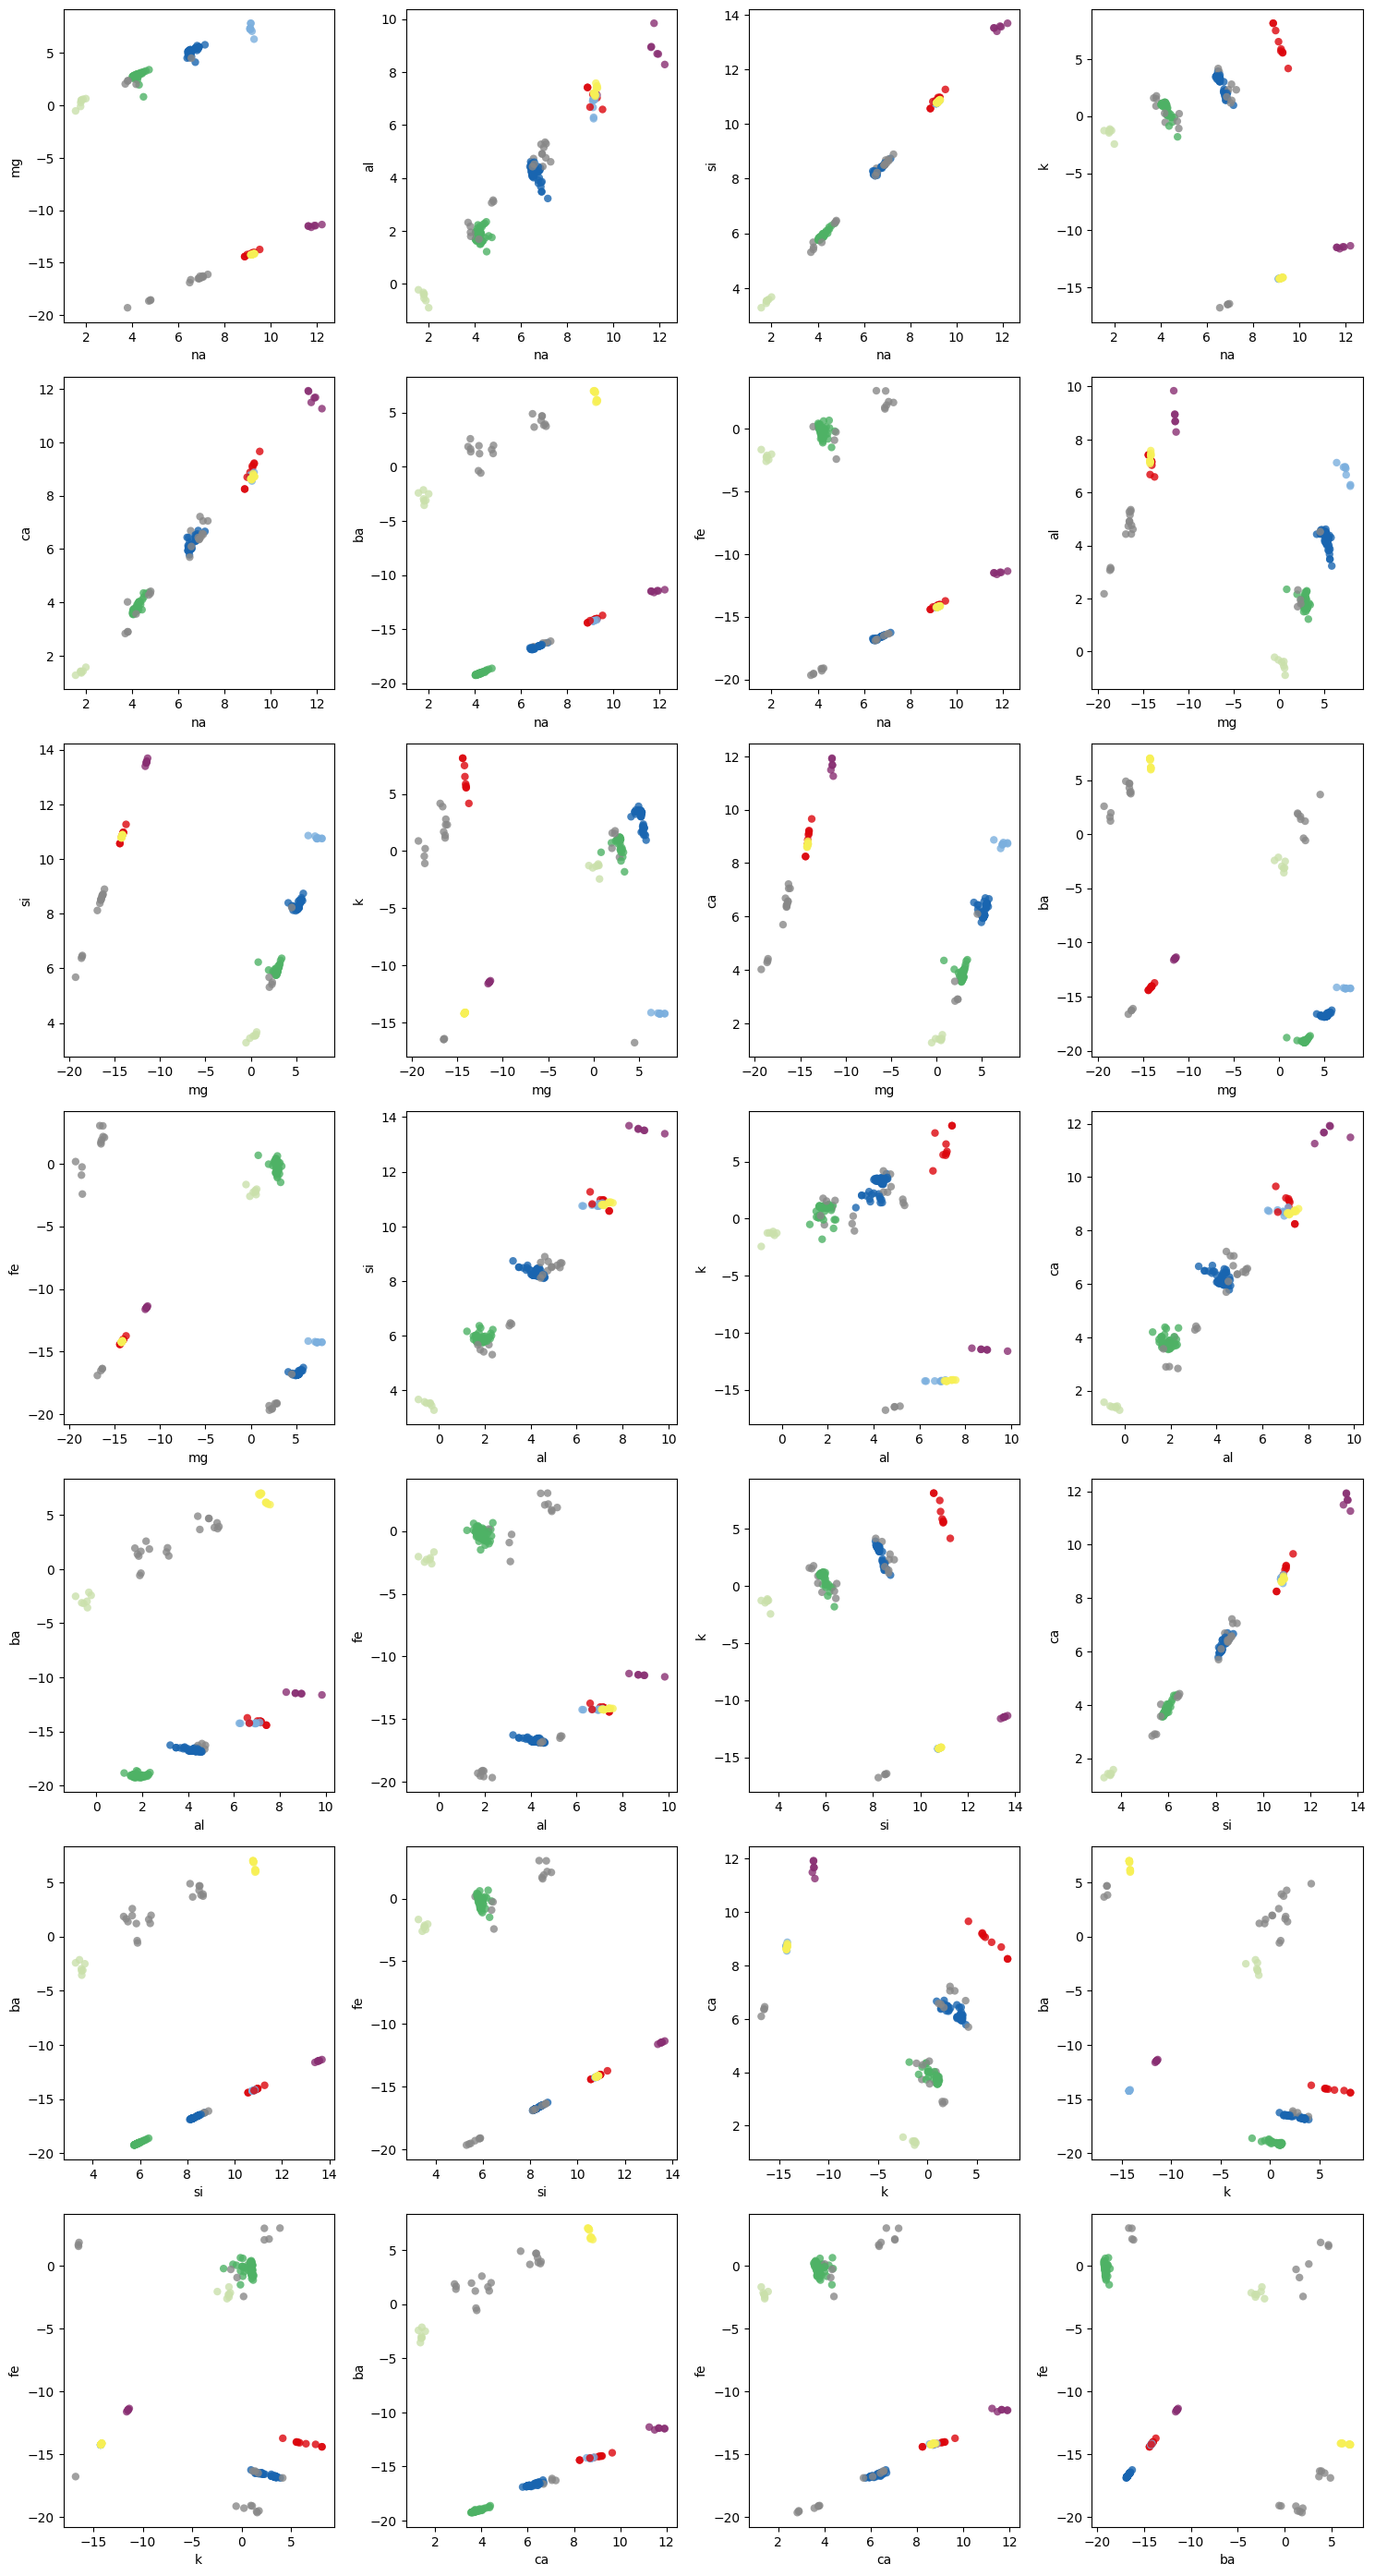

In [ ]:
clDBS7 = cluster.DBSCAN(eps=2, min_samples=6).fit(X)
clDBS7_labels, map_labels = h.relabel_clusters_size(clDBS7.labels_)

print( np.bincount(clDBS7_labels+1) )

h.plot_data(X, names, pairs, clDBS7_labels)

## Evaluation

Finally, we are ready to evaluate quality of each clustering. Also, we will compare individual clustering to each other. Finally, since we have a label for each sample, we can use that as a reference and compare clusterings with the ground truth.

Besides that, we are going to perform k-means clustering on reduced dataset to see whether it brings any significant improvements:

In [ ]:
rclKM7 = cluster.KMeans(n_clusters=7, n_init=10, random_state=RS).fit(rX)
rclKM_labels7, rmap_labels7 = h.relabel_clusters_size(rclKM7.labels_)

rclKM6 = cluster.KMeans(n_clusters=6, n_init=10, random_state=RS).fit(rX)
rclKM_labels6, rmap_labels6 = h.relabel_clusters_size(rclKM6.labels_)

### Internal evaluation

First, we start by evaluating quality of created clusters (without comparing them to other clustering).

We will compute all metrics mentioned in the lecture, namely:


*   Sum of square distances to centroid (SSDC)
*   Intra-cluster vs. Inter-cluster ratio
*   Silhouette coefficient



In [ ]:
def ssdc(X, labels):
    clusters = np.unique(labels)
    total_ssd = 0

    for cluster in clusters:
        cluster_indices = np.where(labels == cluster)[0]
        samples = X[cluster_indices]
        centroid = np.mean(samples, axis=0)
        squared_distances = np.sum((samples - centroid) ** 2, axis=1)

        total_ssd += np.sum(squared_distances)

    return total_ssd

# ---Taken from the example notebook (then modified)
import scipy.spatial.distance as distance

def intra_inter_ratio(X, labels):
    v_dist = distance.pdist(X)
    Ct = np.tile(labels, (len(labels), 1))
    v_sameclass = distance.squareform((Ct == Ct.T) & (Ct != -1), checks=False)
    v_diffclass = distance.squareform((Ct != Ct.T) & (Ct != -1) & ( -1 != Ct.T), checks=False)
    return np.mean(v_dist[v_sameclass])/np.mean(v_dist[v_diffclass])
# ---

In [ ]:
# --- Taken from the example notebook (then modified)
evl_series = [("KMeans (7)", clKM_labels7),
              ("KMeans (6)", clKM_labels6),
              ("Bisec.KMeans (7)", clBKMn7_labels),
              ("Bisec.KMeans (6)", clBKMn6_labels),
              ("Agg.Complete (7)", clAc7_labels),
              ("Agg.Complete (6)", clAc6_labels),
              ("Agg.Single (6)", clAs6_labels),
              ("Agg.Single (7)", clAs7_labels),
              ("Agg.Average (7)", clAa7_labels),
              ("Agg.Average (6)", clAa6_labels),
              ("DBSCAN", clDBS7_labels),
              ("KMeans (7) - r", rclKM_labels7),
              ("KMeans (6) - r", rclKM_labels6),
             ]
# ---

m = []
for name, labels in evl_series:
    m.append( [name, np.max(labels) + 1, metrics.silhouette_score(X, labels), ssdc(X, labels), intra_inter_ratio(X, labels)] )

stats = pd.DataFrame(m, columns=["Method", "# clusters", "Silhouette", "SSDC", "Distance ratio"])
stats.sort_values(by=["Distance ratio"])

Method  # clusters  Silhouette          SSDC  Distance ratio
10            DBSCAN           7    0.830325   6875.740052        0.035897
0         KMeans (7)           7    0.814734   5425.473397        0.060501
11    KMeans (7) - r           7    0.820875   5398.243063        0.064522
1         KMeans (6)           6    0.791375   7364.913945        0.072793
12    KMeans (6) - r           6    0.803081   6830.906180        0.073697
3   Bisec.KMeans (6)           6    0.739357   9488.932998        0.109020
4   Agg.Complete (7)           7    0.782996   6846.664833        0.144189
2   Bisec.KMeans (7)           7    0.769347   7746.969004        0.147456
5   Agg.Complete (6)           6    0.751497   8419.391337        0.152257
8    Agg.Average (7)           7    0.576043  15744.923501        0.344179
9    Agg.Average (6)           6    0.563280  17126.528133        0.345208
7     Agg.Single (7)           7    0.497098  18781.488242        0.369411
6     Agg.Single (6)           6    0.467973  20092.627724        0.369827

We observe that DBSCAN algorithm seems to create quite cohesive clusters. The same could be said about k-means algorithm (which did well also in the example notebook). Another positive news is that all methods besides single linkage agglomerative achieve silhouette coefficient above 0.5. Regarding all the metrics, notice that there is a significant gap between complete linkage and average linkage results (and the rest of algorithms not performing well). Regarding the clustering on reduced dataset, we see that the reduced dataset did not bring significant improvement with k-means algorithm (results are very similar to those obtained with k-means on the full version of the dataset).

### Comparisons of clusterings

Now, we will compare several pairs of clusterings to each other:

We will consider the following metrics:


*   Purity of clusters
*   Rand score
*   Normalized mutual information (NMI) score

In [ ]:
def purity(c1, c2):

    # taking c2 as reference
    cm = metrics.cluster.contingency_matrix(c2, c1)
    max_in_rows = np.max(cm, axis=1)
    correctly_classified = np.sum(max_in_rows)
    total_samples = np.sum(cm)

    return correctly_classified / total_samples

We will not compare each unordered pair, since that would be unbearable. We will compare top three clusterings and then k-means to the worst performing algorithm --- single linkage agglomerative clustering.

In [ ]:
def compare(c1, c2):
    print( "Purity: ", purity(c1, c2) )
    print( "NMI: ", metrics.normalized_mutual_info_score(c1, c2))
    print("Rand score: ", metrics.rand_score(c1, c2))

Let us start with comparison of k-means with k=7 and k=6:

In [ ]:
compare( clKM_labels7, clKM_labels6 )
print()
compare( clKM_labels6, clKM_labels7 )

Purity:  0.9672897196261683
NMI:  0.9648966823082341
Rand score:  0.994910271598438

Purity:  0.985981308411215
NMI:  0.9648966823082341
Rand score:  0.994910271598438


Let's plot a contingency matrix taking k-means with k=6 as reference (we plot one pair of attributes together with it):

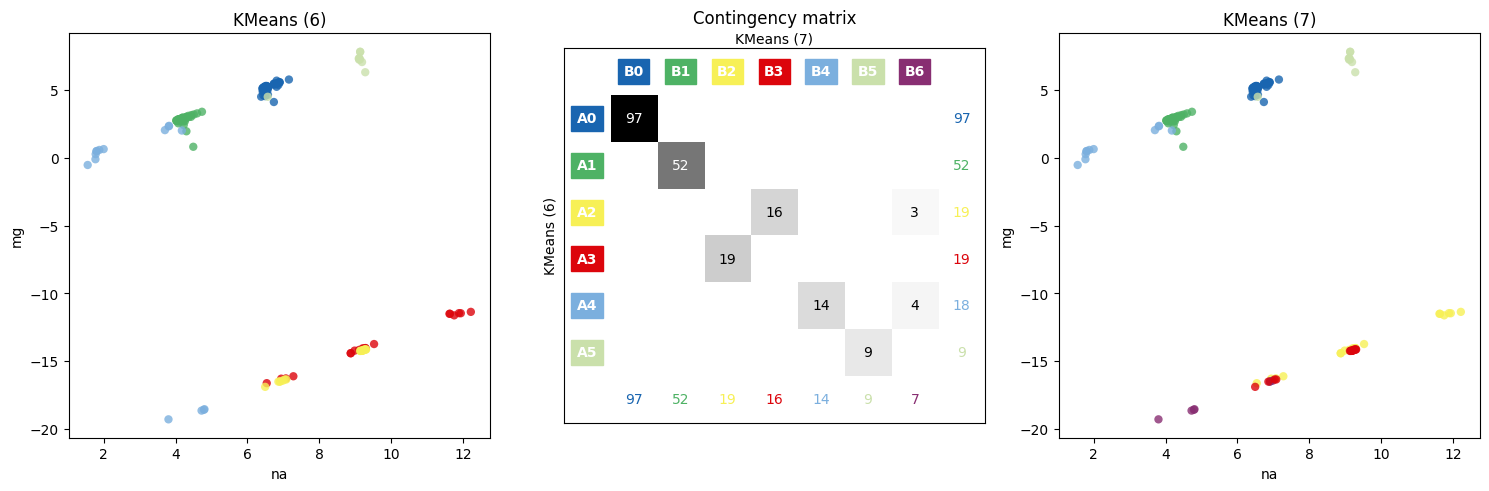

In [ ]:
h.plot_contingency_matrix(clKM_labels6, clKM_labels7 , "KMeans (6)", "KMeans (7)", X, names, pairs[0])
plt.show()

We observe that k-means clustering found similar structures for both k=6 and k=7. For that reason, we are going to compare only k-means with k=7 to the DBSCAN results.

In [ ]:
compare( clKM_labels7, clDBS7_labels )
print()
compare( clDBS7_labels, clKM_labels7 )

Purity:  0.9252336448598131
NMI:  0.8864435293068573
Rand score:  0.9816594269667851

Purity:  0.897196261682243
NMI:  0.8864435293068573
Rand score:  0.9816594269667851


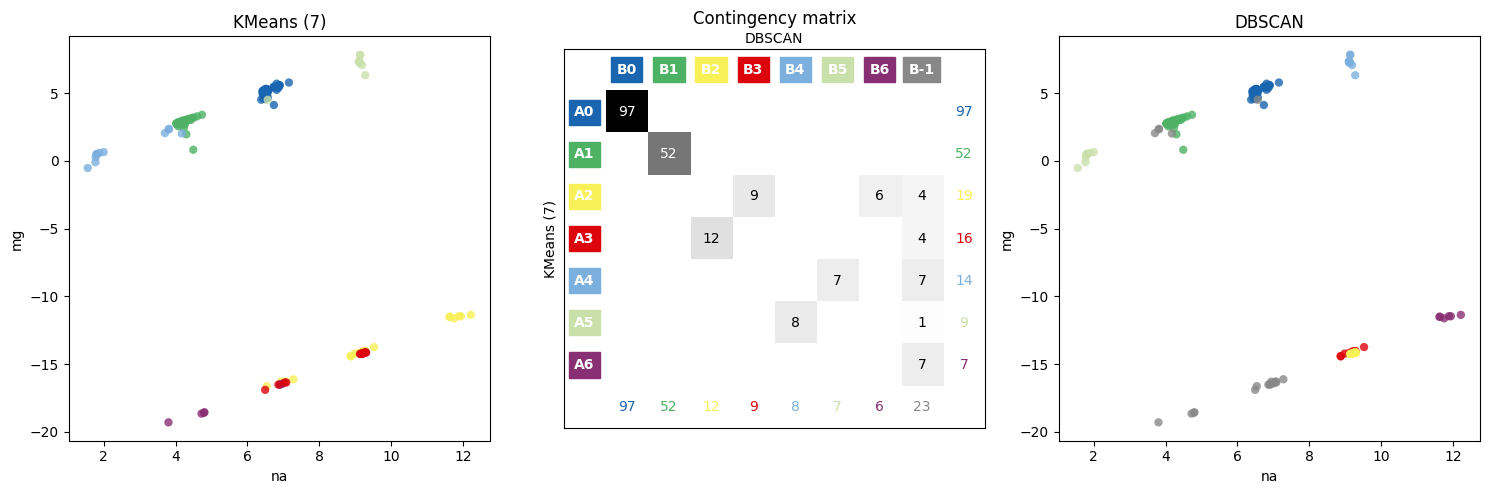

In [ ]:
h.plot_contingency_matrix(clKM_labels7, clDBS7_labels , "KMeans (7)", "DBSCAN", X, names, pairs[0])
plt.show()

We see that the similarity decreased, but the metrics still indicate that the clusterings are not distant.

Next, let us compare k-means with k=7 to single linkage agglomerative results with 7 clusters.

In [ ]:
compare( clKM_labels7, clAs6_labels )
print()
compare( clAs6_labels, clKM_labels7 )

Purity:  0.6542056074766355
NMI:  0.6191409074804815
Rand score:  0.6681146066429731

Purity:  0.9439252336448598
NMI:  0.6191409074804813
Rand score:  0.6681146066429731


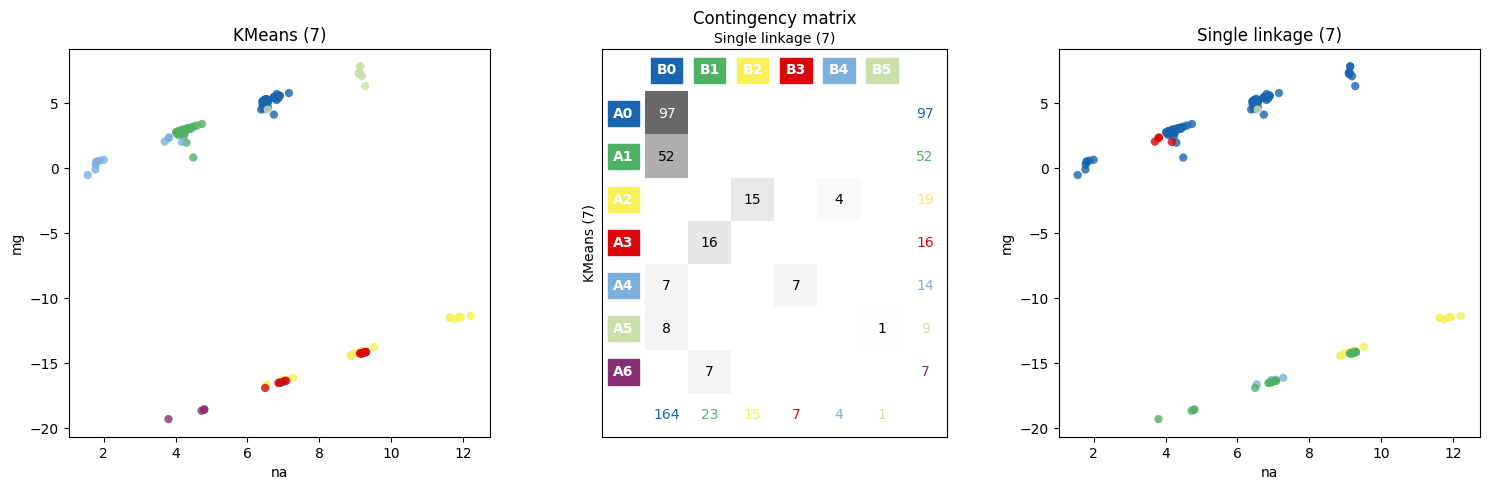

In [ ]:
h.plot_contingency_matrix(clKM_labels7, clAs6_labels , "KMeans (7)", "Single linkage (7)", X, names, pairs[0])
plt.show()

We can see that those two clusterings differ by quite some margin.

Finally, we are going to compare k-means results (k=7) for full and reduced datasets.

In [ ]:
compare( rclKM_labels7, clKM_labels7 )
print()
compare( clKM_labels7, rclKM_labels7 )

Purity:  0.9719626168224299
NMI:  0.9603089948364998
Rand score:  0.9916633758939932

Purity:  0.9672897196261683
NMI:  0.9603089948364998
Rand score:  0.9916633758939932


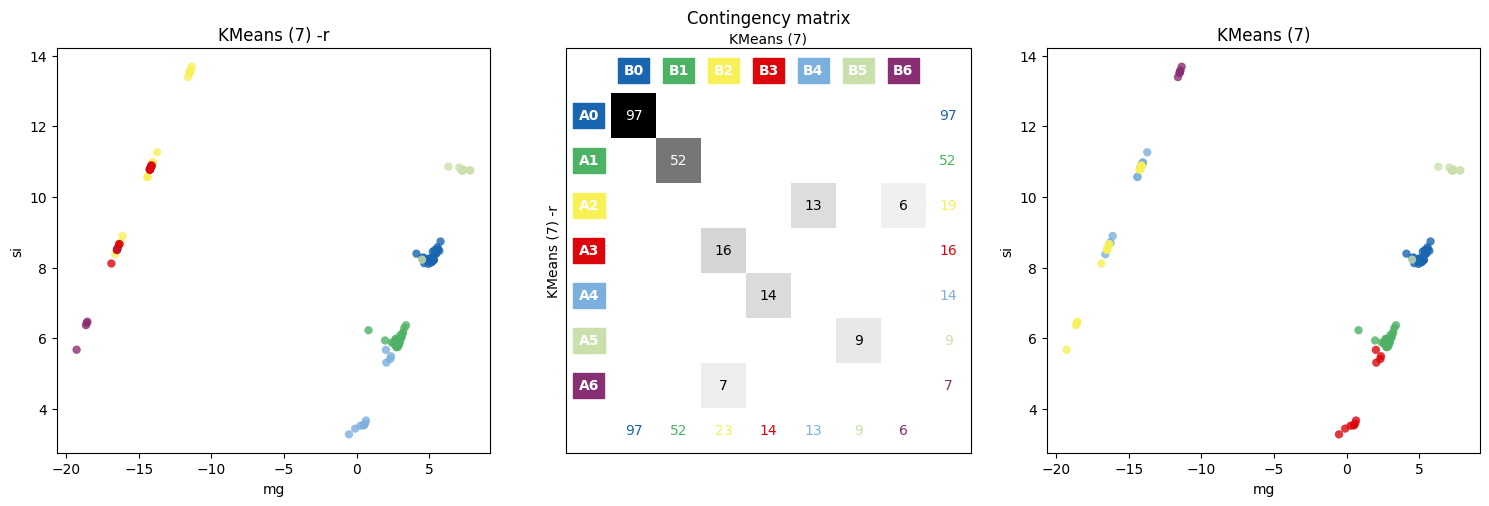

In [ ]:
h.plot_contingency_matrix(clKM_labels7, rclKM_labels7 , "KMeans (7) -r", "KMeans (7)", rX, rnames, rpairs[0])
plt.show()

We observe that the clusterings obtained on reduced and full dataset and almost identical.

### Comparison with ground truth

Since we also have a collection of ground truth labels, we can consider it a reference clustering and compare each clustering to it:

In [ ]:
# --- Copied from the example notebook
map_classes = dict([(cn[1], ci) for ci, cn in enumerate(sorted([(np.sum(label==c), c) for c in np.unique(label)]))])
num_classes = np.array([map_classes[c] for c in label], dtype=int)
gt_labels, map_labels = h.relabel_clusters_size(num_classes)
# ---

Let us visualize the reference clustering:

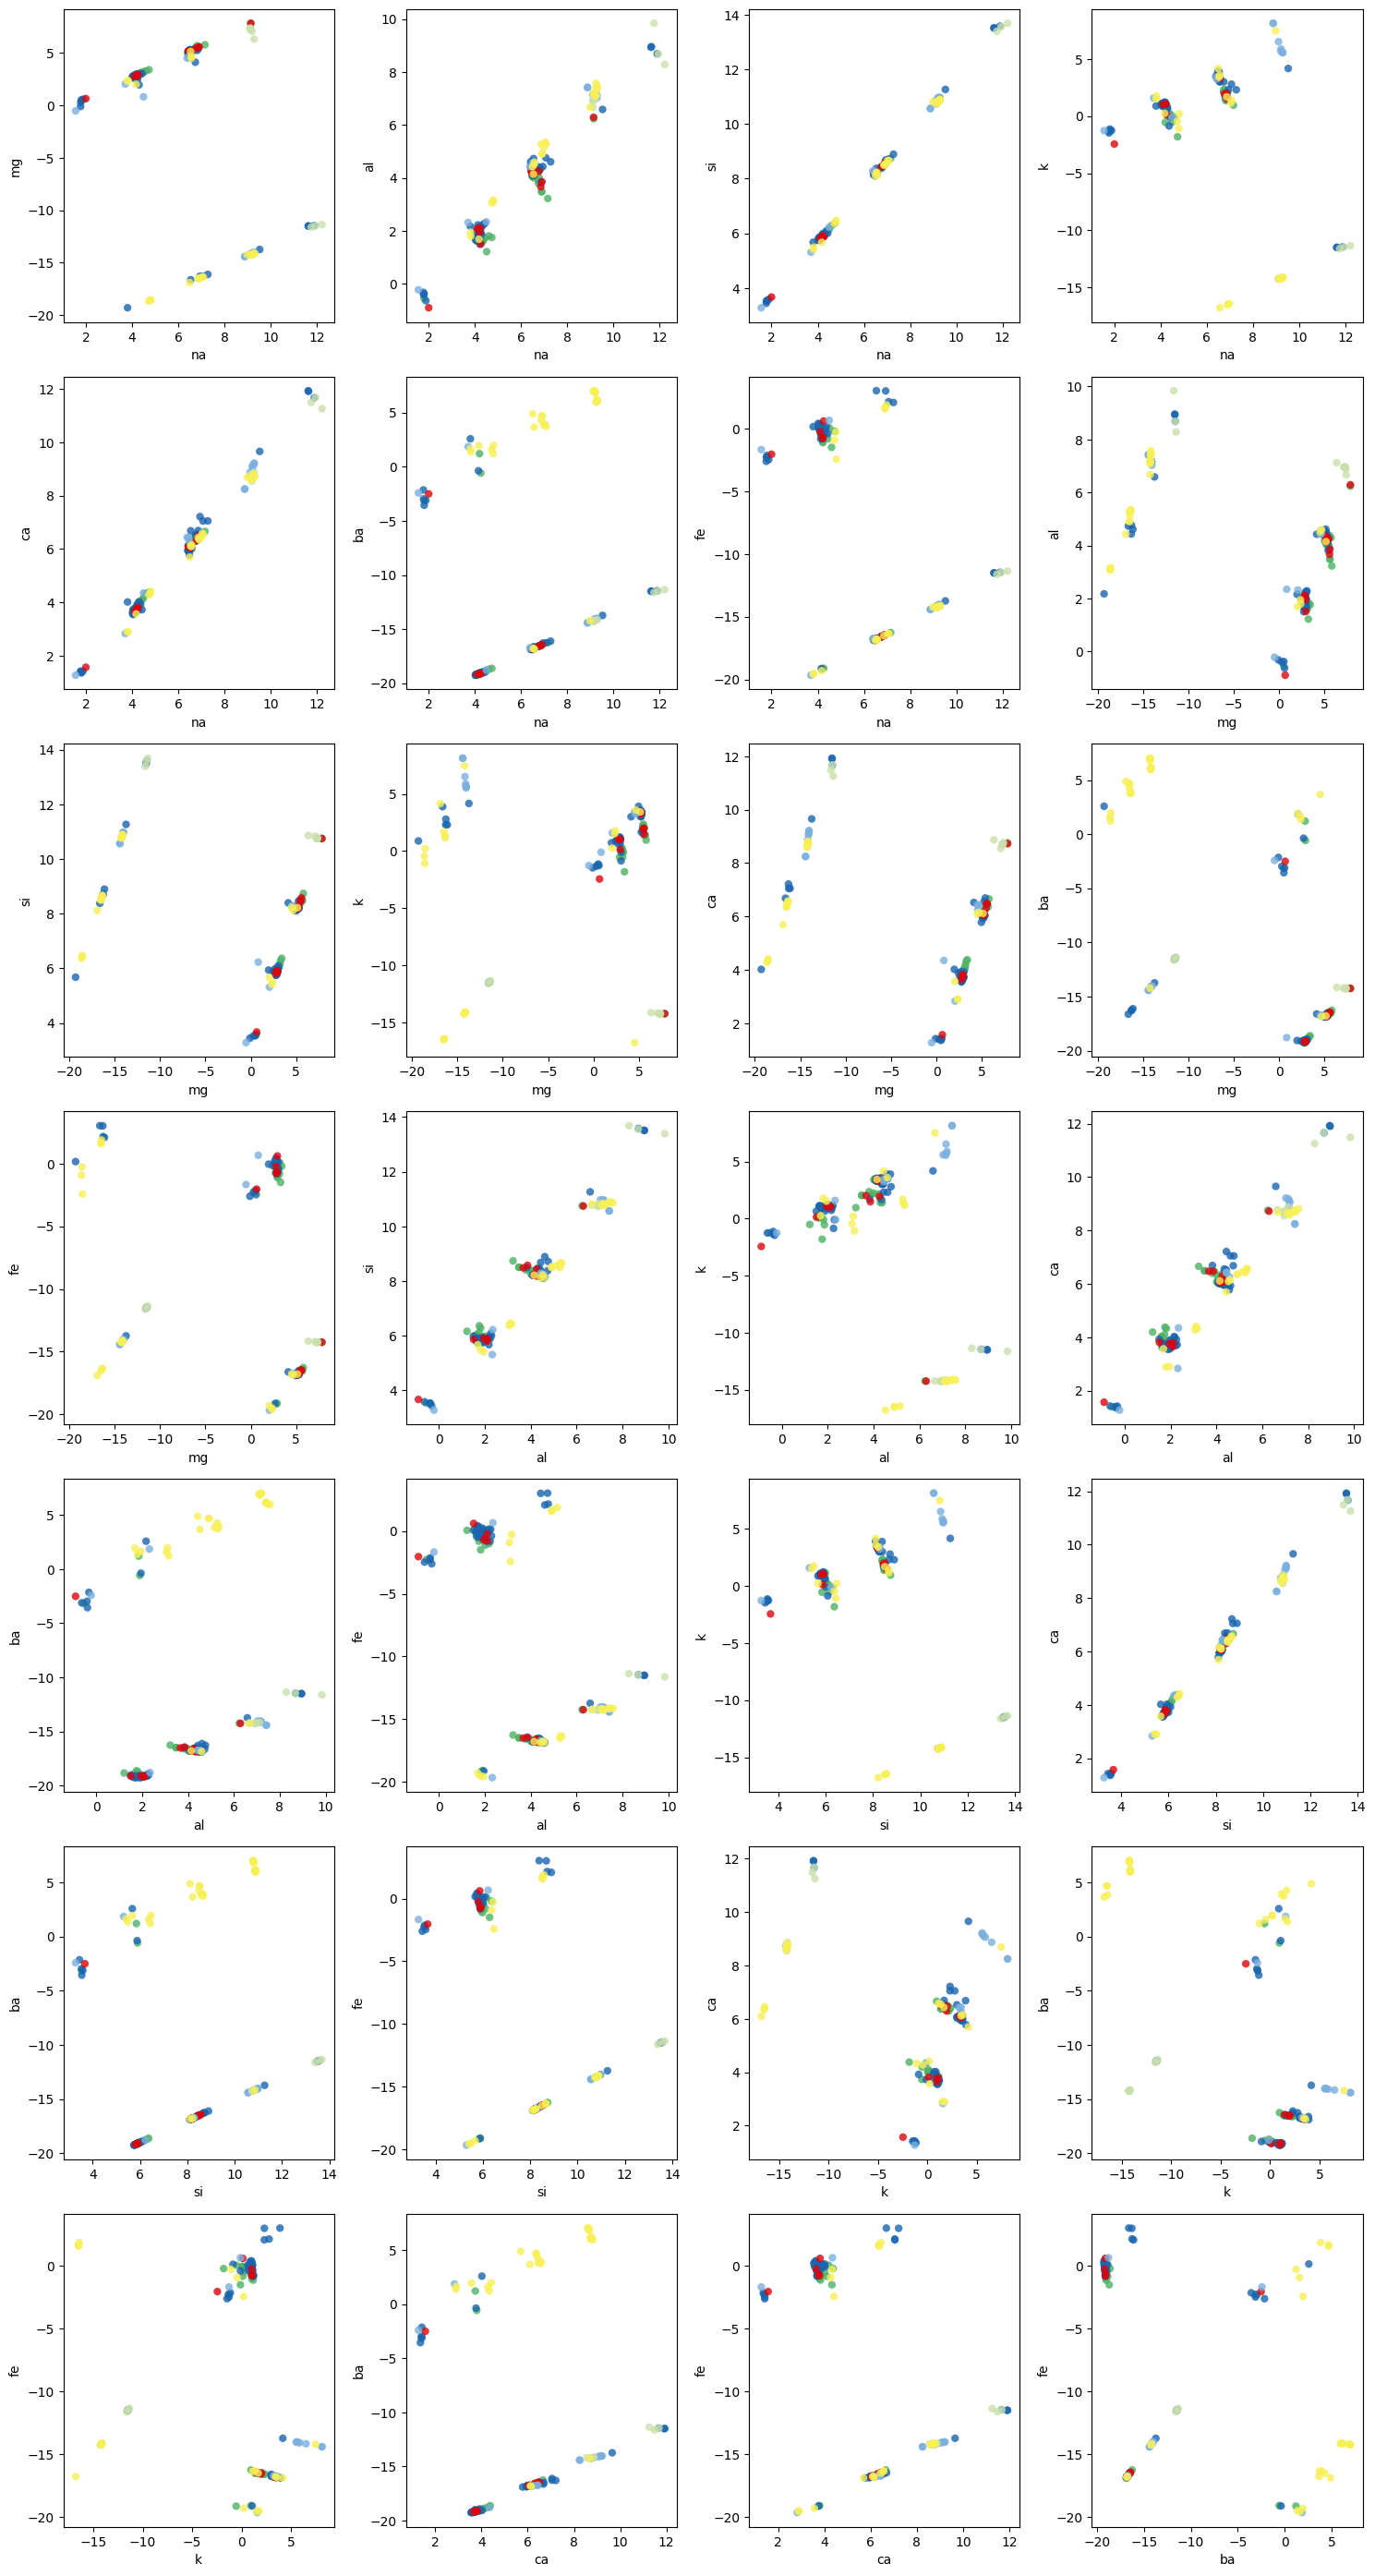

In [ ]:
h.plot_data(X, names, pairs, gt_labels)

I would argue that it is at least very challenging to see the clusters in the 2D projections since the clusters seem to be mixed on each projection.

Next, we can evaluate how cohesive are the expected clusters.

In [ ]:
print("Silhouette coefficient: ", metrics.silhouette_score(X, gt_labels))
print("SSDC: ", ssdc(X, gt_labels))
print("Intra-inter ration: ", intra_inter_ratio(X, gt_labels))

Silhouette coefficient:  -0.04585197665706107
SSDC:  29154.28808904573
Intra-inter ration:  0.6432837136959181


We can see that the expected clusters are not very cohesive.

Now, we are able to compare each clustering to the ground truth. We consider the same metrics as for previous comparisons.



In [ ]:
m = []
for name, labels in evl_series:
    m.append( [name, np.max(labels) + 1, purity(gt_labels, labels), metrics.normalized_mutual_info_score(gt_labels, labels), metrics.rand_score(gt_labels, labels)] )

stats = pd.DataFrame(m, columns=["Method", "# clusters", "Purity", "Rand", "NMI"])
stats.sort_values(by=["NMI"], ascending=False)

Method  # clusters    Purity      Rand       NMI
11    KMeans (7) - r           7  0.509346  0.334661  0.676012
12    KMeans (6) - r           6  0.500000  0.320303  0.673906
10            DBSCAN           7  0.523364  0.337326  0.671449
1         KMeans (6)           6  0.490654  0.317222  0.671010
0         KMeans (7)           7  0.500000  0.317168  0.670396
3   Bisec.KMeans (6)           6  0.495327  0.318879  0.668158
4   Agg.Complete (7)           7  0.509346  0.333017  0.650037
5   Agg.Complete (6)           6  0.495327  0.298901  0.646088
2   Bisec.KMeans (7)           7  0.481308  0.261161  0.638936
8    Agg.Average (7)           7  0.509346  0.410604  0.607345
9    Agg.Average (6)           6  0.509346  0.403671  0.606818
7     Agg.Single (7)           7  0.504673  0.369999  0.565091
6     Agg.Single (6)           6  0.490654  0.346223  0.562985

We observe that no method was able to surpass NMI threshold of 0.7. Also, the purity and rand scores are not optimal. Regarding the relative positions, DBSCAN a k-means are the closest to the ground truth clusters. Since K-means on reduced and full dataset produced highly similar clusters, their comparison to the reference is also very similar.

Notice that we achieved cohesive clusters (see internal metrics of our clusterings), but they seem not to match the intended clusters exactly (the expected clusters are also not very cohesive judging based on computed metrics).

Let us try to decrease the number of expected clusters to create at least some less cohesive clusters to see if we get closer to the expected clustering:

In [ ]:
clKM4 = cluster.KMeans(n_clusters=4, n_init=10, random_state=RS).fit(X)
clKM_labels4, map_labels = h.relabel_clusters_size(clKM4.labels_)

print("NMI: ", metrics.normalized_mutual_info_score(gt_labels, clKM_labels4))
print("Rand: ", metrics.rand_score(gt_labels, clKM_labels4))
print("Purity: ", purity(gt_labels, clKM_labels4))

NMI:  0.27782596795483044
Rand:  0.6214733886183142
Purity:  0.48130841121495327


This step did not help either. We also tried to ommit the CLR transformation, but without any success. It might be the case that the expected clusters are just not very cohesive with regarding given set of attributes. Since our methods try to find cohesive clusters, they have a hard time matching the expected clusters.

Finally, let us compare contingency matrices of top three clusterings and the last one to the ground truth:

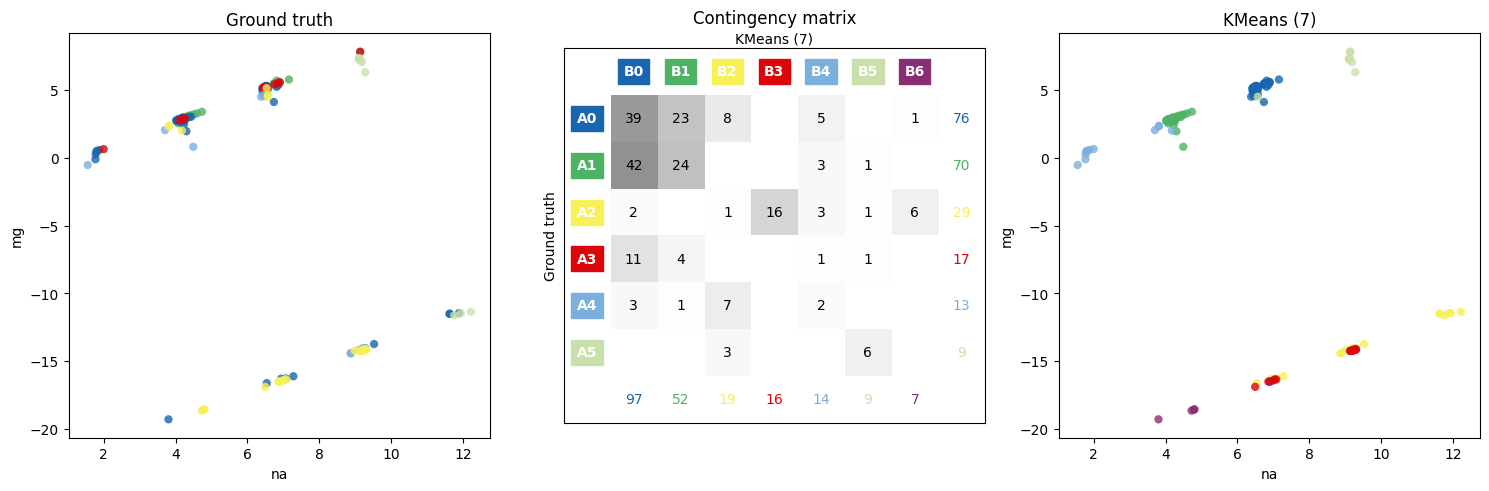

In [ ]:
h.plot_contingency_matrix(gt_labels, clKM_labels7 , "Ground truth", "KMeans (7)", X, names, pairs[0])
plt.show()

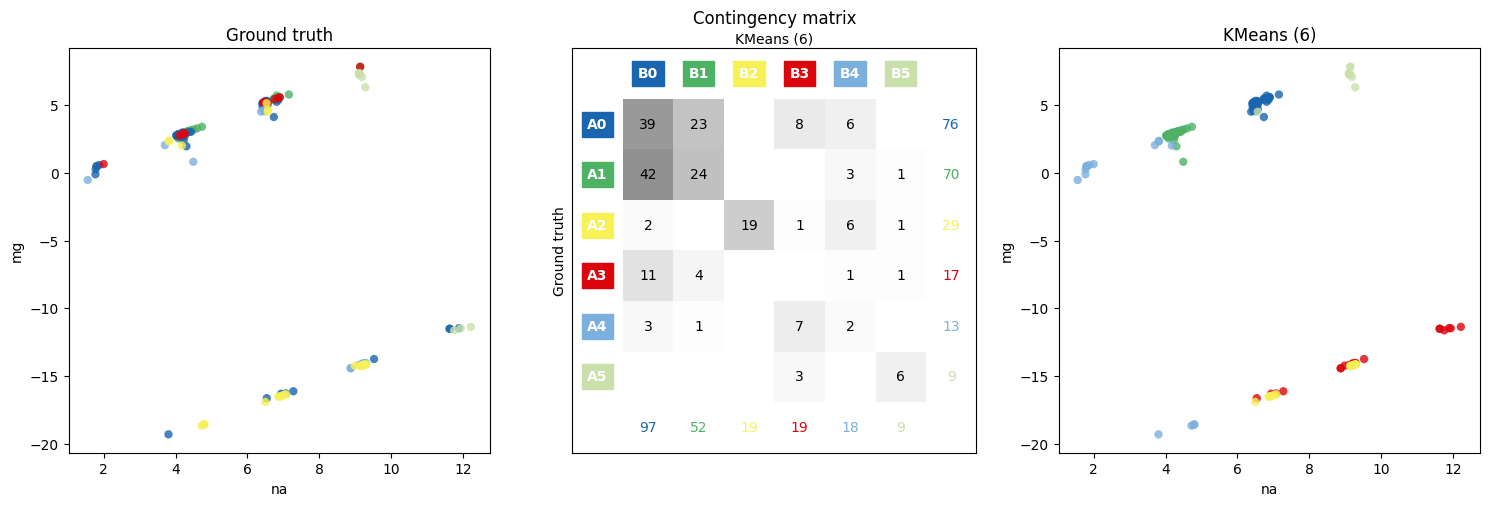

In [ ]:
h.plot_contingency_matrix(gt_labels, clKM_labels6 , "Ground truth", "KMeans (6)", X, names, pairs[0])
plt.show()

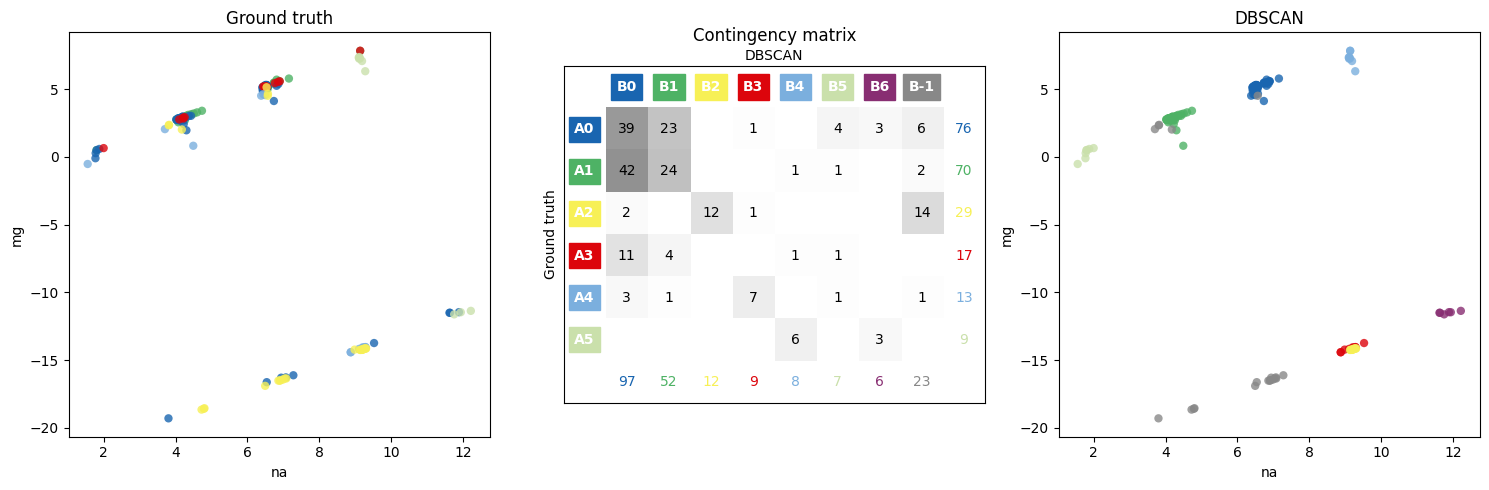

In [ ]:
h.plot_contingency_matrix(gt_labels, clDBS7_labels , "Ground truth", "DBSCAN", X, names, pairs[0])
plt.show()

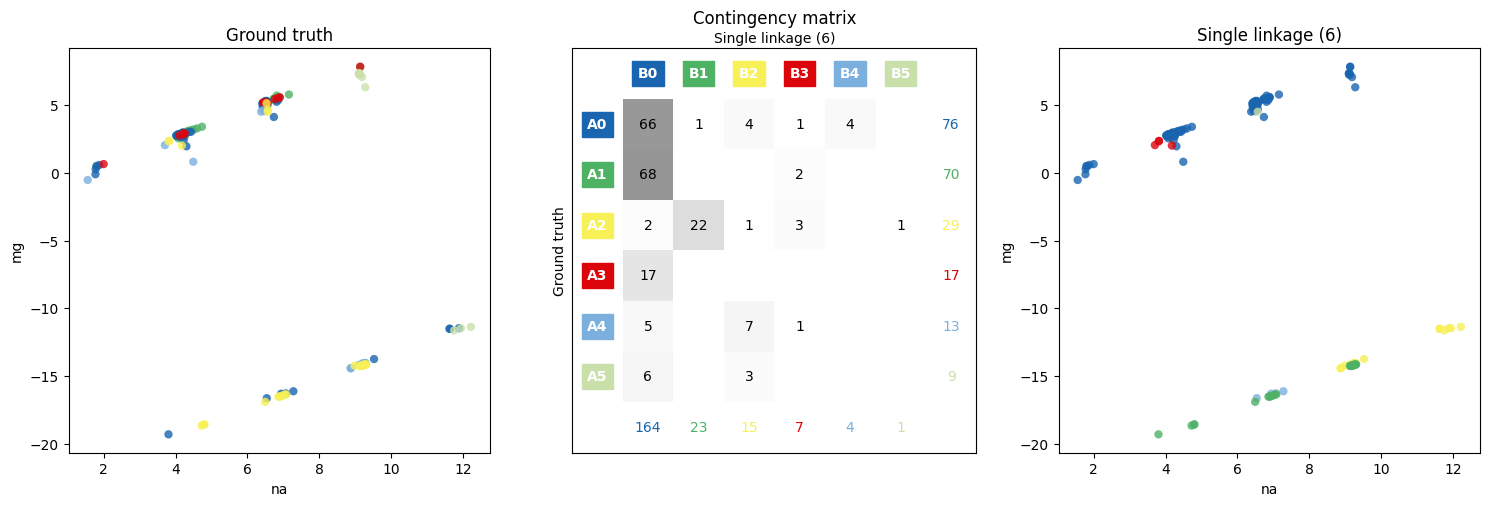

In [ ]:
h.plot_contingency_matrix(gt_labels, clAs6_labels , "Ground truth", "Single linkage (6)", X, names, pairs[0])
plt.show()

From contingency matrices, we observe that there is a substantial difference between expected and obtained clusters.